# Spam Email detection: Feature Engineering
Prepared By Deepa Francis<br>
For BrainStation<br>
On July 31, 2023

# Table of Contents<br>

[1. Features](#ft) <br>
[2. Feature 1: email_to](#et) <br>
- [2.1. xxx](#et1) <br>

[3. Feature 2: email_from](#ef) <br>
- [3.1. Feature hashing](#ef1) <br>
- [3.2. One Hot Encode](#ef1) <br>

[4. Numerical Features](#nf) <br>
[5. Train Test Split](#tts) <br>
[6. Feature 3: subject](#sub) <br>
[7. Feature 4: message](#msg) <br>

In [319]:
# import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from bs4 import BeautifulSoup

import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import warnings
warnings.filterwarnings('ignore')

import random
import re
import string

import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords')
from nltk.corpus import words
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('words')

# display all columns in dataframe
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [320]:
# Functions used in the notebook

#1# Create function for concatenating two dataframes and dropping specific columns from them
def concat_and_drop(df1, df2, columns_to_drop):
    df1.reset_index(drop=True, inplace=True)
    df1 = pd.concat([df1, df2], axis=1)
    df1 = df1.drop(columns=columns_to_drop)
    return df1 

#2# Create function for converting feature hashed sparse matrix to dataframe
def feature_hashed_df(hashed_sparse_matrix):
    # Get the actual number of unique hash values (n_features)
    label_n_features = hashed_sparse_matrix.shape[1]

    # Get the names of the columns resulting from the FeatureHasher
    hashed_columns = [f"hash_{i}" for i in range(label_n_features)]

    # Create a DataFrame using the dense array representation and the concatenated column names
    feature_hashed_df = pd.DataFrame(hashed_sparse_matrix.toarray(), columns=hashed_columns)

    # Add the 'from_' prefix to the DataFrame columns to match the original column names
    feature_hashed_df = feature_hashed_df.add_prefix('email_from_')

    # Reset the DataFrame index
    feature_hashed_df.reset_index(drop=True, inplace=True)

    # View the resulting DataFrame
    return feature_hashed_df

#3# Create function for custom tokenizer
ENGLISH_STOP_WORDS = stopwords.words('english')
ENGLISH_STOP_WORDS.extend(['\n', 'also', 'contenttyp', 'like', 'get', 'mail', 'would', 'email', 'r', 'content', 'transfer'])
stemmer = nltk.stem.PorterStemmer()

def my_tokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    # Remove numbers, stopwords and any tokens that are just empty strings
    for word in listofwords:
        # Exclude numbers and empty strings
        if not (bool(re.search(r'\d', word)) or word == ''):
            if (not word in ENGLISH_STOP_WORDS):
                # Stem words
                stemmed_word = stemmer.stem(word)
                listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

#4# Create function for getting text data from html tags using Beautiful Soup
def extract_HTML_text(html):
    # Ensure input is text
    assert type(html) == str, 'Input must be a string'
    # Instantiate a BeautifulSoup object from the html string using BeautifulSoup
    soup = BeautifulSoup(html, features="html.parser")
    # Return the text content of the soupified html content
    return soup.get_text()

#5# Create function for extracting words from text data
# Load English words from NLTK corpus
nltk_eng_words = set(words.words())

def extract_text_content(text, english_words):
    # Ensure input is a string
    assert type(text) == str 
    # Remove any 'Content-Type' header and its content from the text
    filteredText = re.sub('Content-Type: text\/(plain|html).*','', text)
    # Remove all non-alphabetic characters from the text and keep whitespaces
    characterFilteredText = re.sub(r'[^a-zA-Z\s]', ' ', filteredText)
    # Initialize an empty list to store English words found in the text
    englishWordOnlyTextArr = []
    # Tokenize the text into words using the NLTK word tokenizer
    for word in nltk.word_tokenize(characterFilteredText):
        # Convert the word to lowercase for case-insensitive comparison
        lower_word = word.lower()
        # Check if the lowercase word is present in the set of English words
        # provided as 'english_words' and if the word's length is greater than 1
        if lower_word in nltk_eng_words and len(word) > 1:
            # If the word is an English word and has a length greater than 1,
            # add it to the list of English words found in the text
            englishWordOnlyTextArr.append(word)
        elif lower_word == 'i' or lower_word == 'a':
            # Include 'i' and 'a' in the list, even though they may not be present
            # in the set of English words provided. These are common single-letter
            # English words and might be meaningful in certain contexts.
            englishWordOnlyTextArr.append(word)
    return ' '.join(englishWordOnlyTextArr)


#6# Create a function for sentence embedding
def sentence2vec(text):
    """
    Embed a sentence by averaging the word vectors of the tokenized text. Out-of-vocabulary words are replaced by the zero-vector.
    -----
    
    Input: text (string)
    Output: embedding vector (np.array)
    """
    tokenized = simple_preprocess(text)
    
    word_embeddings = [np.zeros(300)]
    for word in tokenized:
        # if the word is in the model then embed
        if word in model:
            vector = model[word]
        # add zeros for out-of-vocab words
        else:
            vector = np.zeros(300)
            
        word_embeddings.append(vector)
    
    # average the word vectors
    sentence_embedding = np.stack(word_embeddings).mean(axis=0)
    
    return sentence_embedding

#7# Create a function to get the word embedding or a default embedding if the word is out-of-vocabulary (OOV)
def get_embedding(word, model, default_embedding=None):
    try:
        return model[word]
    except KeyError:
        if default_embedding is not None:
            return default_embedding
        else:
            # Return a zero vector if no default embedding is provided
            return np.zeros(model.vector_size)

In [174]:
# Load the sampled data
sampled_data = pd.read_csv('sampled_data.csv') 

In [175]:
# Instantiate sample features and target
X_sample = sampled_data.drop(columns="label")
y_sample = sampled_data["label"]

In [176]:
# Check the shapes of feature and target
print('The shape of Features: ', X_sample.shape)
print('The shape of Target: ', y_sample.shape)

The shape of Features:  (40000, 4)
The shape of Target:  (40000,)


In [177]:
# Check the features
X_sample.head()

,subject,email_to,email_from,message
0,Re: [sugar] new Sugar dependency: libtelepathy...,sugar@laptop.org,Dafydd Harries <daf@rhydd.org>,Content-Type: text/plain; charset=us-ascii\nCo...
1,Rev 307: enable TCP keepalives in http://samba...,samba-cvs@samba.org,tridge@samba.org,----------------------------------------------...
2,[perl #43105] [PATCH] function mmd.c::mmd_expa...,"""OtherRecipients of perl Ticket #43105"": ;","""Bernhard Schmalhofer via RT"" <parrotbug-follo...",> > What happens when NULL is not a consective...
3,Re: [R] Appropriate regression model for categ...,R-help@stat.math.ethz.ch,Robert A LaBudde <ral@lcfltd.com>,"At 01:45 PM 6/12/2007, Tirtha wrote:\n>Dear us..."
4,TONIGHT ON SHOWBIZ TONIGHT - CNN HEADLINE PRIM...,ktwarwic@flax9.UWATERLOO.CA,Showbiz Tonight <showbiz@mail.cnn.com>,"Content-type: text/plain; charset=""US-ASCII"" T..."


There are four features. All of them are text data. Lets take look into them one by one

<a id = "et"></a>
## 2. Feature 1: email_to

Since the goal of the machine learning task is spam detection, the recipient email address might not provide relevant information for the specific task. Dropping the "email_to" feature allows the model to focus solely on the nature of incoming emails.<br>

If the dataset contains a large number of unique email addresses in the "email_to" feature, including it as a categorical feature could lead to high dimensionality. High-dimensional feature spaces can pose challenges in terms of computational complexity, memory usage, and model interpretability. <br>

By dropping the "email_to" feature, the dimensionality of the feature space is reduced, simplifying the machine learning process.

In [178]:
# Drop the 'email_to' column
X_sample.drop('email_to', axis=1, inplace=True)
# Confirm the changes
X_sample.head()

,subject,email_from,message
0,Re: [sugar] new Sugar dependency: libtelepathy...,Dafydd Harries <daf@rhydd.org>,Content-Type: text/plain; charset=us-ascii\nCo...
1,Rev 307: enable TCP keepalives in http://samba...,tridge@samba.org,----------------------------------------------...
2,[perl #43105] [PATCH] function mmd.c::mmd_expa...,"""Bernhard Schmalhofer via RT"" <parrotbug-follo...",> > What happens when NULL is not a consective...
3,Re: [R] Appropriate regression model for categ...,Robert A LaBudde <ral@lcfltd.com>,"At 01:45 PM 6/12/2007, Tirtha wrote:\n>Dear us..."
4,TONIGHT ON SHOWBIZ TONIGHT - CNN HEADLINE PRIM...,Showbiz Tonight <showbiz@mail.cnn.com>,"Content-type: text/plain; charset=""US-ASCII"" T..."


<a id = "ef"></a>
## 3. Feature 2: email_from

email_from feature has the email address of the sender. It has a pattern. So we can extract displayname, username, email host and domain extension from this.

In [179]:
# Check unique values of email_from
X_sample['email_from'].value_counts().count()

22619

We are using pandas string method called extract. It is used to extract substrings from the "email_from" column that match the specified regular expression pattern.

In [180]:
# clean email_from
df_email_from = pd.DataFrame()
df_email_from["from_display_name"] = X_sample["email_from"].str.extract(r"^([^<]+)")
df_email_from["from_username"] = X_sample["email_from"].str.extract(r"<(.*?)@")
df_email_from["from_host"] = X_sample["email_from"].str.extract(r"@(\w+)")
df_email_from["from_domain"] = X_sample["email_from"].str.extract(r"@[\w.]+\.(\w+)")

# Removing double quotes (") and commas (,) from "display_name" column
df_email_from["from_display_name"] = df_email_from["from_display_name"].str.replace(r'[",]', '')

# View the extracted results
df_email_from.head()

,from_display_name,from_username,from_host,from_domain
0,Dafydd Harries,daf,rhydd,org
1,tridge@samba.org,NaN,samba,org
2,"""Bernhard Schmalhofer via RT""",parrotbug-followup,parrotcode,org
3,Robert A LaBudde,ral,lcfltd,com
4,Showbiz Tonight,showbiz,mail,com


Now we need to clean this dataframe before making it into features

In [181]:
# Number of missing values in the email_from dataframe
print(f"Number of missing values: {df_email_from.isna().sum().sum()}")

Number of missing values: 5336


In [182]:
# Check column wise count of missing values
df_email_from.isna().sum()

from_display_name     753
from_username        2938
from_host               4
from_domain          1641
dtype: int64

Replace null values and missing values with 'Unkown' string, since we don't have this information available.

In [183]:
df_email_from['from_display_name'] = df_email_from['from_display_name'].replace([np.nan, ''], 'Unknown')
df_email_from['from_username'] = df_email_from['from_username'].replace([np.nan, ''], 'Unknown')
df_email_from['from_host'] = df_email_from['from_host'].replace([np.nan, ''], 'Unknown')
df_email_from['from_domain'] = df_email_from['from_domain'].replace([np.nan, ''], 'Unknown')

# Check column wise count of missing values
df_email_from.isna().sum()

from_display_name    0
from_username        0
from_host            0
from_domain          0
dtype: int64

Lets closely examine each of the extracted features.

**Email Host: from_host**

In [184]:
# Unique email hosts
print('There are', df_email_from['from_host'].value_counts().count(), ' email hosts')

There are 13158  email hosts


Lets see which are the top 20 email hosts

from_host
samba         2851
gmail         2692
yahoo         1028
mail           939
broadcast      637
cbsig          549
messaging      336
stats          335
hotmail        320
parrotcode     312
foxnews        223
pelmorex       205
debian         197
gmx            183
flax9          169
ebs            168
verizon        161
keionline      156
calcium        152
wgz            150
Name: count, dtype: int64


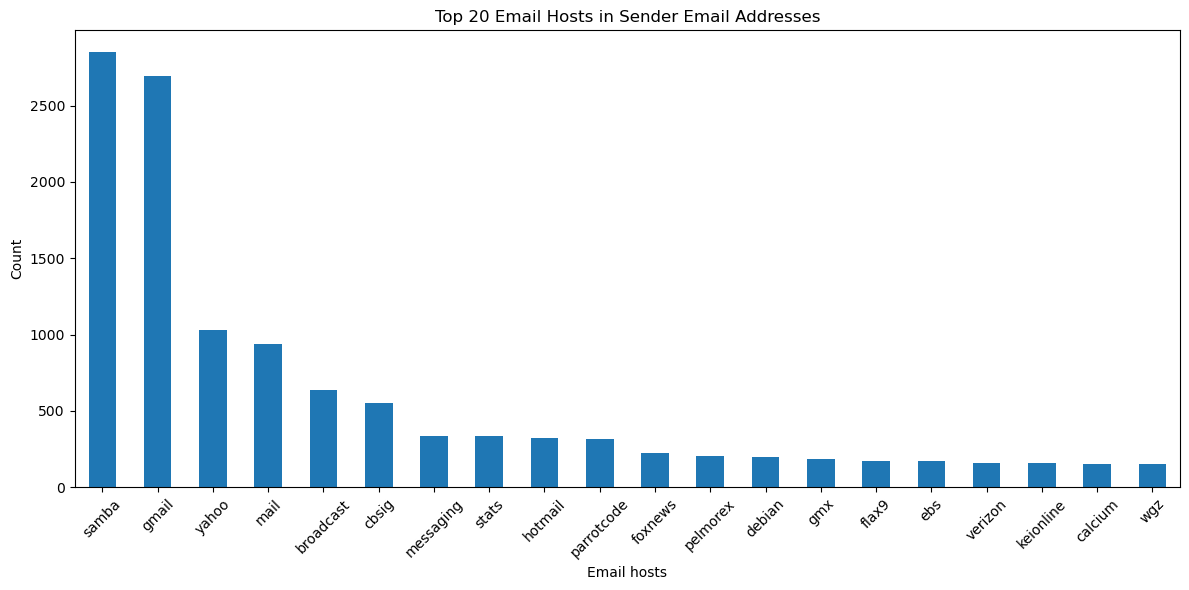

In [185]:
top_20_counts = df_email_from['from_host'].value_counts().head(20)
print(top_20_counts)

# Plotting the top 20 value counts as a bar plot
plt.figure(figsize=(12, 6))
top_20_counts.plot(kind='bar')
plt.xlabel('Email hosts')
plt.ylabel('Count')
plt.title('Top 20 Email Hosts in Sender Email Addresses')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From the top 20 email hosts, lets keep the popular ones and club the rest of them together as 'Others'.

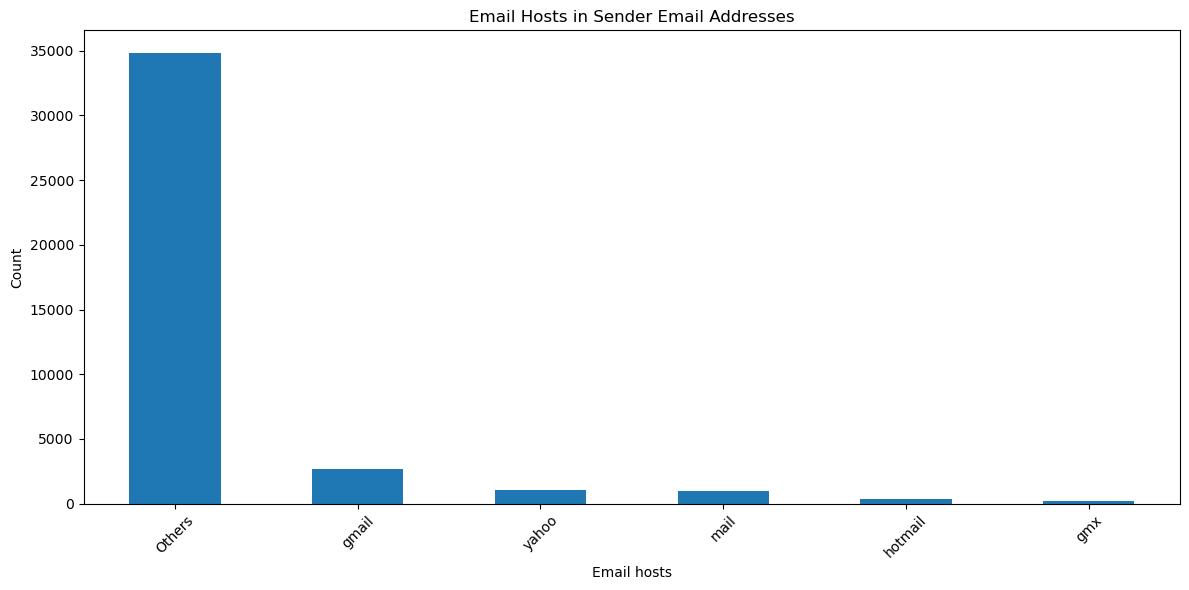

In [186]:
# List of email hosts to keep
popular_email_hosts = ['gmail', 'yahoo', 'mail', 'hotmail', 'gmx']

# Map the 'from_host' column to 'Others' using lambda function and .apply
df_email_from['from_host'] = df_email_from['from_host'].apply(lambda host: host if host in popular_email_hosts else 'Others')

# Display new value counts for Sender email host
email_host_counts = df_email_from['from_host'].value_counts()

# Plotting the top 20 value counts as a bar plot
plt.figure(figsize=(12, 6))
email_host_counts.plot(kind='bar')
plt.xlabel('Email hosts')
plt.ylabel('Count')
plt.title('Email Hosts in Sender Email Addresses')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

View the top email host categories removing 'Others'

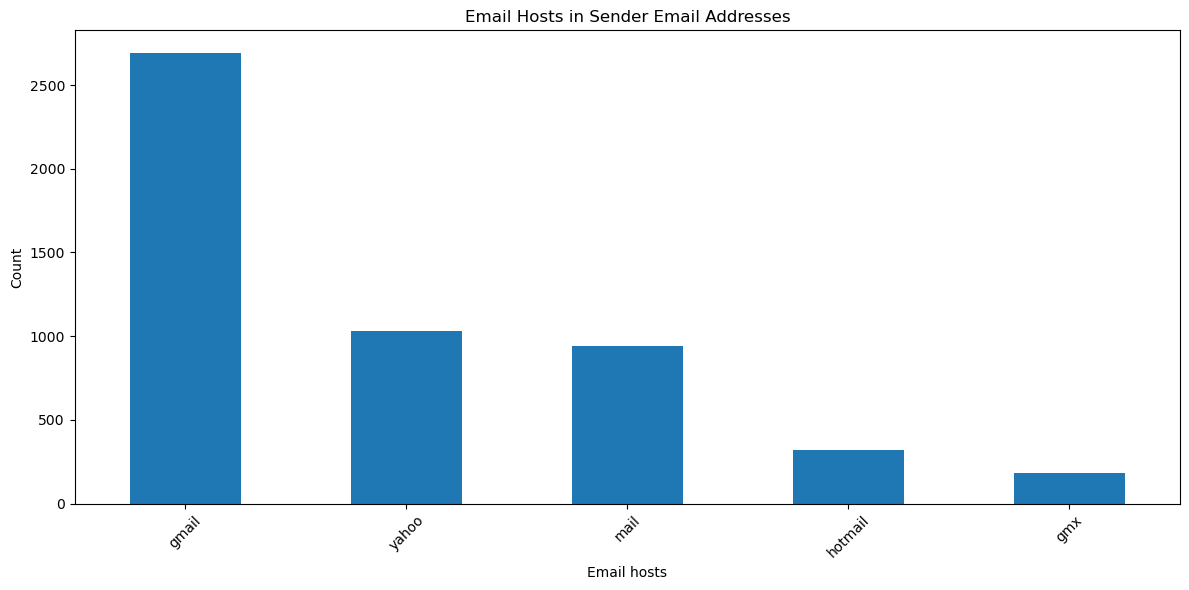

In [187]:
# Filter out the 'Others' category from the value counts
top_email_hosts = email_host_counts.drop('Others')

# Plotting the top 20 value counts as a bar plot
plt.figure(figsize=(12, 6))
top_email_hosts[:20].plot(kind='bar')
plt.xlabel('Email hosts')
plt.ylabel('Count')
plt.title('Email Hosts in Sender Email Addresses')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [188]:
# Check the new feature classes
df_email_from.sample(5)

,from_display_name,from_username,from_host,from_domain
4163,Dan Williams,dcbw,Others,com
5600,David Collier-Brown,davec-b,Others,com
12182,James E Keenan,jkeen,Others,net
11141,Alexandra HEUMBER,Alexandra.HEUMBER,Others,org
26574,"""Customer Support""",bounce,Others,fm


**Email Host: from_domain**

In [189]:
# Unique email domain
print('There are', df_email_from['from_domain'].value_counts().count(), ' email domain extensions')

There are 191  email domain extensions


Lets see which are the top 20 email domains

from_domain
com        20027
org         5252
net         3521
Unknown     1641
ca          1220
uk          1187
edu          933
de           706
biz          418
au           382
it           318
fr           292
jp           230
br           211
nl           208
dk           178
cz           164
COM          152
ch           145
pl           138
Name: count, dtype: int64


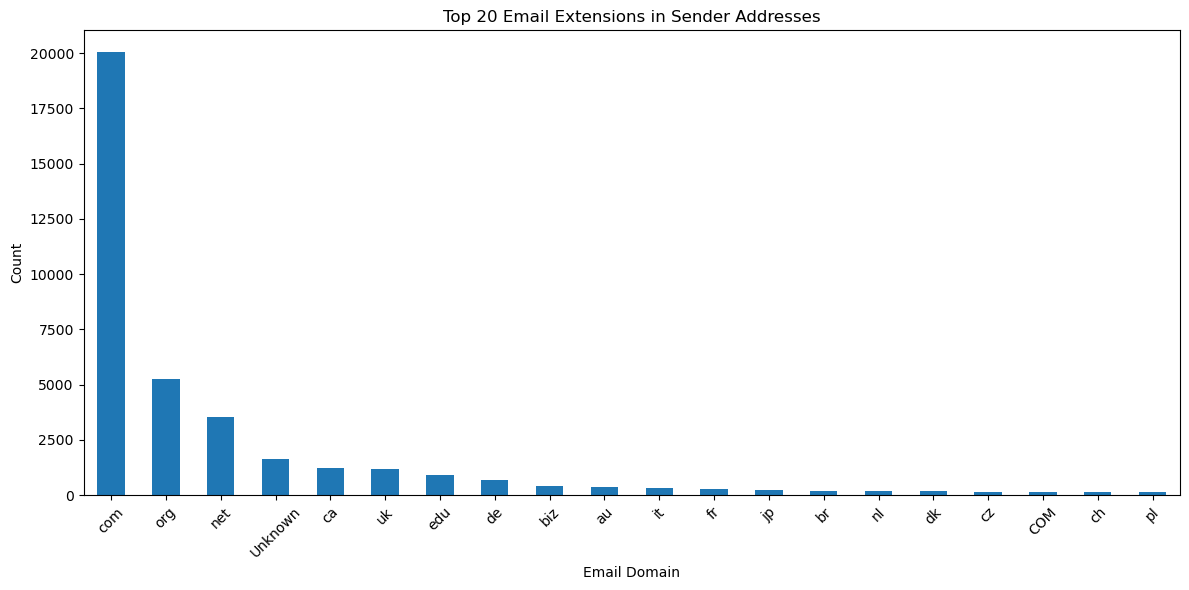

In [190]:
top_20_counts = df_email_from['from_domain'].value_counts().head(20)
print(top_20_counts)

# Plotting the top 20 value counts as a bar plot
plt.figure(figsize=(12, 6))
top_20_counts.plot(kind='bar')
plt.xlabel('Email Domain')
plt.ylabel('Count')
plt.title('Top 20 Email Extensions in Sender Addresses')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From the top 20 email domains, lets keep the popular ones and club the rest of them together as 'Others'.

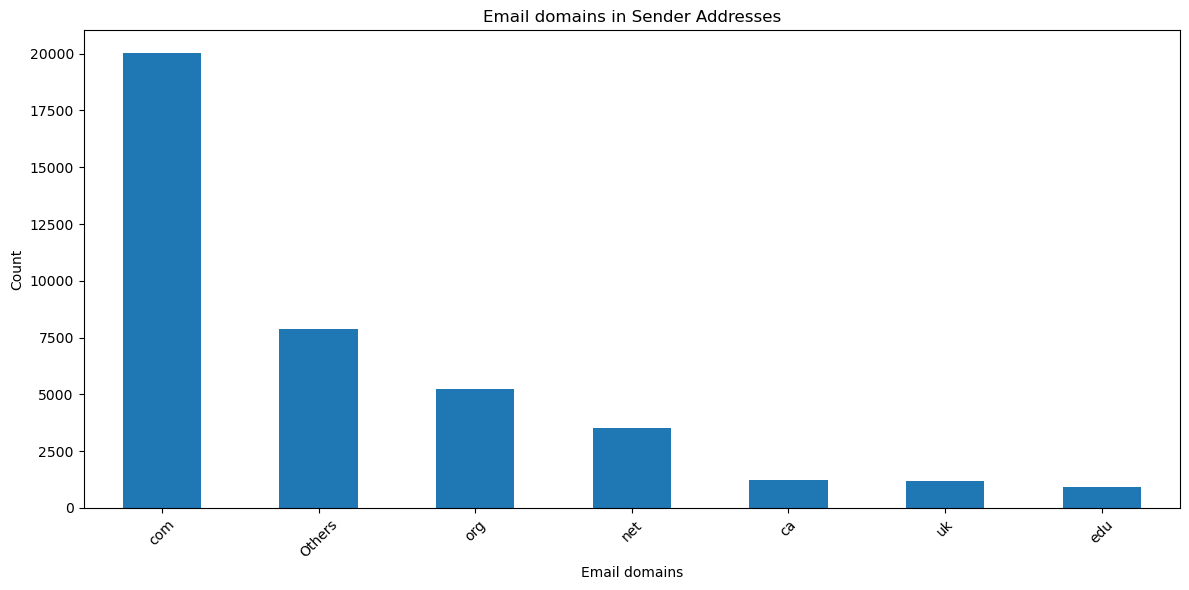

In [191]:
# List of email domains to keep
known_email_domains = ['com', 'org', 'net', 'uk', 'ca', 'edu']

# Map the 'from_domain' column to 'Others' using lambda function and .apply
df_email_from['from_domain'] = df_email_from['from_domain'].apply(lambda domain: domain if domain in known_email_domains else 'Others')

# Display new value counts for Sender email host
email_domain_counts = df_email_from['from_domain'].value_counts()

# Plotting the top 20 value counts as a bar plot
plt.figure(figsize=(12, 6))
email_domain_counts.plot(kind='bar')
plt.xlabel('Email domains')
plt.ylabel('Count')
plt.title('Email domains in Sender Addresses')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [192]:
# Check the new feature classes
df_email_from.sample(5)

,from_display_name,from_username,from_host,from_domain
3087,Common Dreams,commondreams,mail,org
38637,Leonard,ffraid,Others,net
13151,"""Patrick Wang""",pwang,Others,edu
18868,tridge@samba.org,Unknown,Others,org
14718,Unknown,alert,Others,com


Finally, join the extracted features to Feature dataframe and remove the email_from feature.

In [193]:
# Use concat_and_drop function for joining the extracted features
X_sample = concat_and_drop(X_sample, df_email_from, 'email_from')
# Check the changes
X_sample.head()

,subject,message,from_display_name,from_username,from_host,from_domain
0,Re: [sugar] new Sugar dependency: libtelepathy...,Content-Type: text/plain; charset=us-ascii\nCo...,Dafydd Harries,daf,Others,org
1,Rev 307: enable TCP keepalives in http://samba...,----------------------------------------------...,tridge@samba.org,Unknown,Others,org
2,[perl #43105] [PATCH] function mmd.c::mmd_expa...,> > What happens when NULL is not a consective...,"""Bernhard Schmalhofer via RT""",parrotbug-followup,Others,org
3,Re: [R] Appropriate regression model for categ...,"At 01:45 PM 6/12/2007, Tirtha wrote:\n>Dear us...",Robert A LaBudde,ral,Others,com
4,TONIGHT ON SHOWBIZ TONIGHT - CNN HEADLINE PRIM...,"Content-type: text/plain; charset=""US-ASCII"" T...",Showbiz Tonight,showbiz,mail,com


<a id = "nf"></a>
## 4. Numerical Features

We are going to extract some numerical features from subject and message features. We can count the number of words in each of these features and add it as an additional feature.
Extremely short or long subjects/messages might contain unique characteristics. The word count feature allows machine learning algorithms to identify and potentially leverage such patterns.

In [194]:
# Add feature: Word count of hotel name
X_sample['subject_Word_Count'] = X_sample['subject'].str.split().str.len()

# Add feature: Word count of hotel name
X_sample['message_Word_Count'] = X_sample['message'].str.split().str.len()

# Check the changes
X_sample.head()

,subject,message,from_display_name,from_username,from_host,from_domain,subject_Word_Count,message_Word_Count
0,Re: [sugar] new Sugar dependency: libtelepathy...,Content-Type: text/plain; charset=us-ascii\nCo...,Dafydd Harries,daf,Others,org,6,165
1,Rev 307: enable TCP keepalives in http://samba...,----------------------------------------------...,tridge@samba.org,Unknown,Others,org,7,95
2,[perl #43105] [PATCH] function mmd.c::mmd_expa...,> > What happens when NULL is not a consective...,"""Bernhard Schmalhofer via RT""",parrotbug-followup,Others,org,9,198
3,Re: [R] Appropriate regression model for categ...,"At 01:45 PM 6/12/2007, Tirtha wrote:\n>Dear us...",Robert A LaBudde,ral,Others,com,8,209
4,TONIGHT ON SHOWBIZ TONIGHT - CNN HEADLINE PRIM...,"Content-type: text/plain; charset=""US-ASCII"" T...",Showbiz Tonight,showbiz,mail,com,10,523


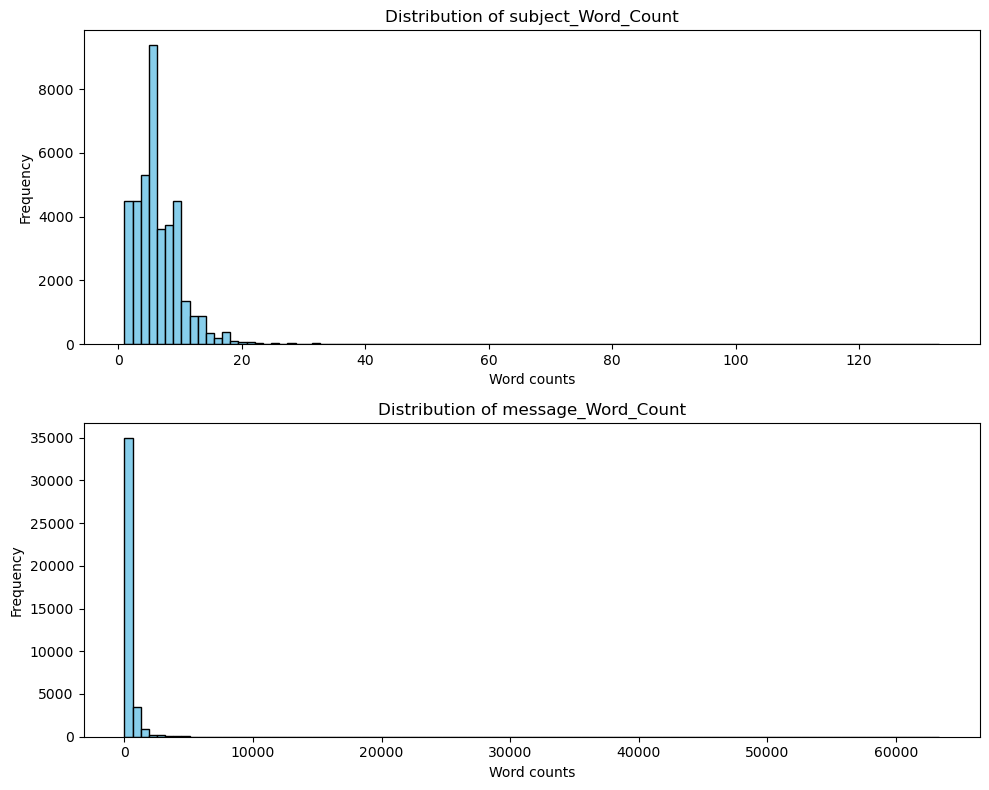

In [195]:
# Checking the distribution of numerical features
column_names = ['subject_Word_Count', 'message_Word_Count']

# Create subplots to plot multiple features in the same figure
num_features = len(column_names)
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(10, 4 * num_features))

# Plot histograms for each numerical feature
for i in range(num_features):
    feature_values = X_sample[column_names[i]]
    
    # Plot a histogram for the feature
    axes[i].hist(feature_values, bins=100, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Distribution of {column_names[i]}')
    axes[i].set_xlabel('Word counts')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

We are going to clip the values for outlier handling. In subject word counts, everything above 20 word counts are set to 20.<br>
In the message word count, we are clipping theshold is set to 434 based on the research which showed that an average email message is 434.48 words. Please refer the source given below <br>
https://blog.aweber.com/learn/average-email-length.htm#:~:text=The%20average%20email%20length,approximately%203.3%20minutes%20to%20read


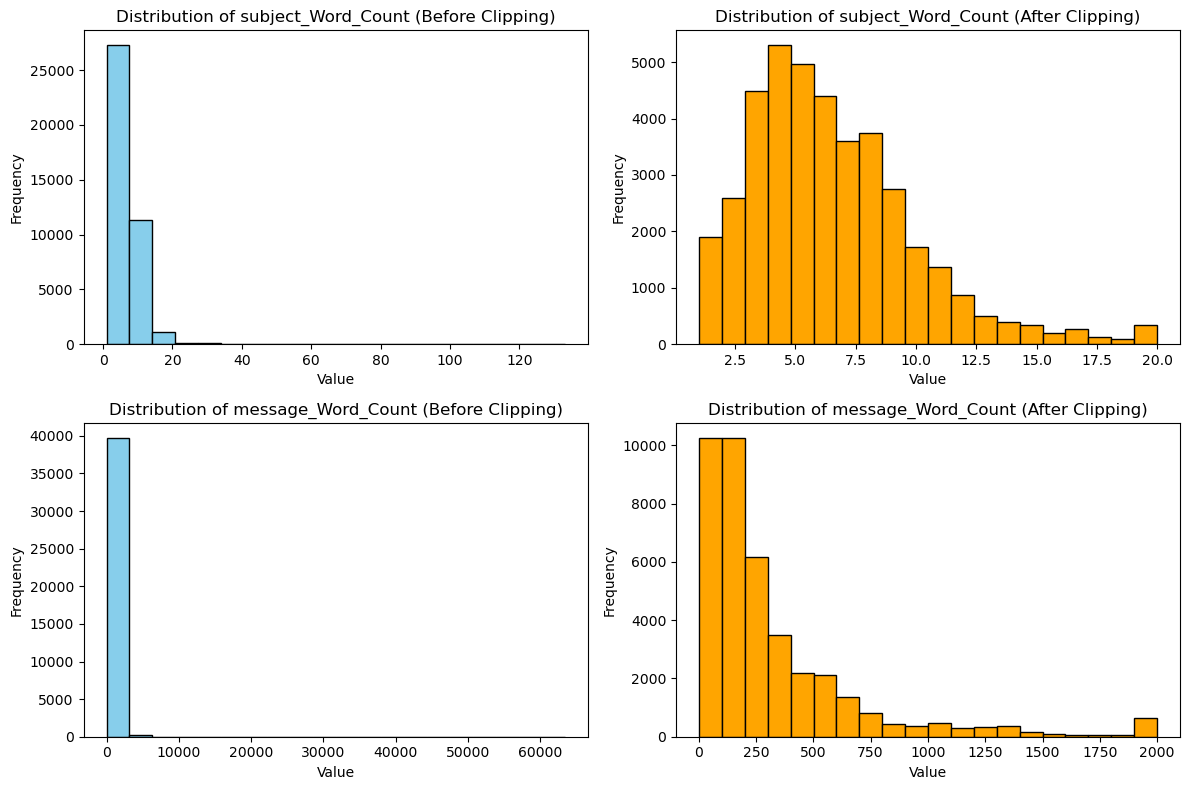

In [196]:
# Clipping outliers
X_sample['subject_Word_Count_clipped'] = X_sample['subject_Word_Count'].clip(upper=20)
X_sample['message_Word_Count_clipped'] = X_sample['message_Word_Count'].clip(upper=2000)

# Column names for reference
column_names1 = ['subject_Word_Count', 'message_Word_Count']
column_names2 = ['subject_Word_Count_clipped', 'message_Word_Count_clipped']

# Create subplots to plot multiple features in the same figure
num_features = len(column_names)
fig, axes = plt.subplots(nrows=num_features, ncols=2, figsize=(12, 4 * num_features))

# Plot histograms before and after clipping for each numerical feature
for i in range(num_features):
    # Before clipping
    axes[i, 0].hist(X_sample[column_names1[i]], bins=20, color='skyblue', edgecolor='black')
    axes[i, 0].set_title(f'Distribution of {column_names[i]} (Before Clipping)')
    axes[i, 0].set_xlabel('Word count')
    axes[i, 0].set_ylabel('Frequency')

    # After clipping
    clipped_feature = X_sample[column_names2[i]].clip(upper=2000)  # Clip the data again for the "After Clipping" histogram
    axes[i, 1].hist(clipped_feature, bins=20, color='orange', edgecolor='black')
    axes[i, 1].set_title(f'Distribution of {column_names[i]} (After Clipping)')
    axes[i, 1].set_xlabel('Word Count')
    axes[i, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [199]:
# Drop the original word count columns
X_sample = X_sample.drop(['subject_Word_Count', 'message_Word_Count'], axis=1)
# Check the changes
X_sample.head()

,subject,message,from_display_name,from_username,from_host,from_domain,subject_Word_Count_clipped,message_Word_Count_clipped
0,Re: [sugar] new Sugar dependency: libtelepathy...,Content-Type: text/plain; charset=us-ascii\nCo...,Dafydd Harries,daf,Others,org,6,165
1,Rev 307: enable TCP keepalives in http://samba...,----------------------------------------------...,tridge@samba.org,Unknown,Others,org,7,95
2,[perl #43105] [PATCH] function mmd.c::mmd_expa...,> > What happens when NULL is not a consective...,"""Bernhard Schmalhofer via RT""",parrotbug-followup,Others,org,9,198
3,Re: [R] Appropriate regression model for categ...,"At 01:45 PM 6/12/2007, Tirtha wrote:\n>Dear us...",Robert A LaBudde,ral,Others,com,8,209
4,TONIGHT ON SHOWBIZ TONIGHT - CNN HEADLINE PRIM...,"Content-type: text/plain; charset=""US-ASCII"" T...",Showbiz Tonight,showbiz,mail,com,10,523


<a id = "tts"></a>
## 5. Train Test split

Before proceeding to the next steps of preprocessing, it is essential to split the data into train, test and validation sets.
In order to prevent data leakage and ensure fair evaluation, a common practice is to fit a transformer or preprocessing step on the training set (X_train) and then apply the learned transformation to the validation set (X_validation) for hyperparameter optimization and score the test set (X_test). 

By fitting the transformer only on X_train, we ensure that the feature extraction process is based solely on the training data, avoiding any information from the validation and test sets influencing the transformation. This helps maintain the integrity of the validation and test sets as truly unseen data during the training process.

However, it is important to note that we do not fit the transformer on the remainder data because it can be used in the future for cross validating models. So the preprocessing steps that we are going to do next can be applied to X_remainder at that time.

In [200]:
# Taking a chunk for our 20% test set
X_remainder, X_test, y_remainder, y_test = train_test_split(X_sample,
                                                            y_sample,
                                                            test_size=0.3,
                                                            random_state=42,
                                                            stratify=y_sample)

# Splitting the remainder into train and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(X_remainder,
                                                                y_remainder, 
                                                                test_size = 0.2,
                                                                random_state=42, 
                                                                stratify=y_remainder)

In [203]:
# Shapes of Split data
print("Shape of X_train:", X_train.shape)
print("Shape of X_validation:", X_validation.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of X_remainder:", X_remainder.shape)

Shape of X_train: (22400, 8)
Shape of X_validation: (5600, 8)
Shape of X_test: (12000, 8)
Shape of X_remainder: (28000, 8)


In [202]:
# Checking the head of X_train
X_train.head()

,subject,message,from_display_name,from_username,from_host,from_domain,subject_Word_Count_clipped,message_Word_Count_clipped
8442,Re: Proposal for SAMBA_3_0/README.Coding,-----BEGIN PGP SIGNED MESSAGE-----\nHash: SHA1...,"""Gerald (Jerry) Carter""",jerry,Others,org,4,93
20936,In he ballantine,Does Size Matter?'\n____\n\n60% of WOMEN said ...,"""Janell Newell""",xykcidra,Others,net,3,129
28124,Why seek? Choose any love pi11 you want!,Content-Type: multipart/alternative;\n\tbounda...,"""Stephen""",john,Others,Others,8,338
36843,invitation to fill in the vacant position of a...,Content-Type: text/html;\nContent-Transfer-Enc...,"""SCC""",dofwgzveglxj,Others,com,11,568
1486,"Windows server returning ""non specific error c...","Windows CIFS server (2003) is returning a ""Non...","""Murali Bashyam""",mbcoder,gmail,com,7,175


In [205]:
# Reset the indexes of the split data
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
X_validation.reset_index(drop=True, inplace=True)
X_remainder.reset_index(drop=True, inplace=True)

<a id = "fh"></a>
### 3.1. Feature Hashing

In [67]:
# Compute the unique value counts of each column in X_train
column_counts = X_train.nunique()
print(column_counts)

subject               14235
message               22400
from_display_name     11891
from_username         11858
from_host                 6
from_domain               7
subject_Word_Count       40
message_Word_Count     1871
dtype: int64


Diaplay name and username can be considered high cardinality for one-hot encoding and could lead to high-dimensional dataset for label encoding. They also contains text data do not have a natural numerical order.<br>

Feature hashing, also known as the hashing trick, is particularly useful for high cardinality categorical features because it helps to reduce dimensionality while still capturing useful information.It involves applying a hash function to map the feature values to a fixed number of indices (or buckets), which we call n_features.

The main purpose of feature hashing is to reduce the dimensionality of high-cardinality categorical or textual data, where the number of unique feature values is large. Instead of explicitly encoding each feature value as a separate column, feature hashing maps the values to a fixed number of hash buckets. <br>

Host and Domain can be one hot encoded since we reduced its cardinality.

Sources:<br>
https://youtu.be/uhHZM_2sS5s

**Optimizing n_features**
First we optimize the number of features to be used by comparing the scores of logistic regression.

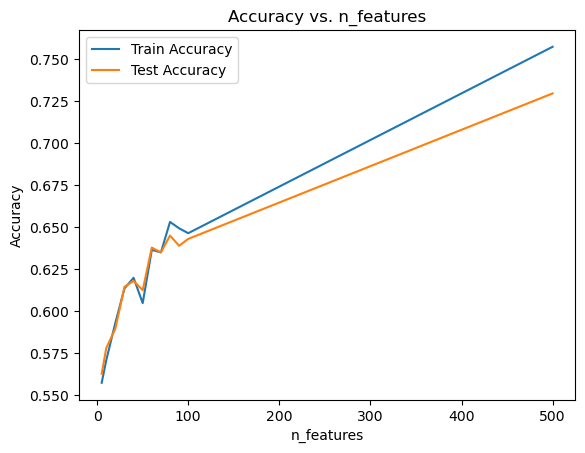

In [214]:
# Columns to apply feature hashing
columns_to_hash = ['from_display_name', 'from_username']

# Initialize lists to store n_features and accuracies
n_features_values = [5,10,20,30,40,50,60,70,80,90,100,500]
train_scores = []
val_scores = []

for n_features in n_features_values:
    # Initialize the FeatureHasher
    hasher = FeatureHasher(n_features=n_features, input_type='string')

    # Apply feature hashing to X_train
    X_train_hashed = hasher.transform(X_train[columns_to_hash].values.astype(str))

    # Train a model on the hashed features
    logit = LogisticRegression()
    logit.fit(X_train_hashed, y_train)

    # Apply feature hashing to X_test
    X_val_hashed = hasher.transform(X_validation[columns_to_hash].values.astype(str))

    # Calculate train accuracy
    train_accuracy = logit.score(X_train_hashed, y_train)
    train_scores.append(train_accuracy)

    # Calculate test accuracy
    val_accuracy = logit.score(X_val_hashed, y_validation)
    val_scores.append(val_accuracy)

# Plot the graph
plt.plot(n_features_values, train_scores, label='Train Accuracy')
plt.plot(n_features_values, val_scores, label='Test Accuracy')
plt.xlabel('n_features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. n_features')
plt.legend()
plt.show()

The accuracy is going up as we increase number of features. However, it leads to overfitting. So we can get the best number of features, where the train and validation accuracies are the closest and doesnt overfit. Looking at the graph, we decide to keep the minimum validation score to be 60%.

In [215]:
# Find the indices where val_scores > 0.60
val_indices = np.where(np.array(val_scores) > 0.60)[0]

# Calculate the absolute difference between train_scores and val_scores
abs_diff = np.abs(np.array(train_scores) - np.array(val_scores))

# Find the index with the minimum absolute difference among the selected indices
valid_indices = val_indices[abs_diff[val_indices].argmin()]

# Get the corresponding best_n_features value
best_n_features = n_features_values[valid_indices]

best_n_features

70

Compute the scores of feature hashing with the best n_feature

In [218]:
# Initialize the FeatureHasher with best n_features
hasher = FeatureHasher(n_features=best_n_features, input_type='string')

# Apply feature hashing to X_train
X_train_hashed = hasher.transform(X_train[columns_to_hash].values.astype(str))

# Train a model on the hashed features
logit = LogisticRegression()
logit.fit(X_train_hashed, y_train)
best_train_accuracy = logit.score(X_train_hashed, y_train)
best_test_accuracy = logit.score(X_test_hashed, y_test)
print('Final Feature Hashing Logistic Regression Train accuracy is {:.2f}%'.format(best_train_accuracy*100))
print('Final Feature Hashing Logistic Regression Test accuracy is {:.2f}%'.format(best_test_accuracy*100))

Final Feature Hashing Logistic Regression Train accuracy is 63.50%
Final Feature Hashing Logistic Regression Test accuracy is 63.16%


Next, convert the result to data frame and check the feature hashed dataframe.

In [221]:
# Create hashed X_train dataframe
X_train_hashed_df = feature_hashed_df(X_train_hashed)
print(f'The shape of feature hashed X_train is {X_train_hashed_df.shape}')
# Check the values
X_train_hashed_df.head()

The shape of feature hashed X_train is (22400, 70)


,email_from_hash_0,email_from_hash_1,email_from_hash_2,email_from_hash_3,email_from_hash_4,email_from_hash_5,email_from_hash_6,email_from_hash_7,email_from_hash_8,email_from_hash_9,email_from_hash_10,email_from_hash_11,email_from_hash_12,email_from_hash_13,email_from_hash_14,email_from_hash_15,email_from_hash_16,email_from_hash_17,email_from_hash_18,email_from_hash_19,email_from_hash_20,email_from_hash_21,email_from_hash_22,email_from_hash_23,email_from_hash_24,email_from_hash_25,email_from_hash_26,email_from_hash_27,email_from_hash_28,email_from_hash_29,email_from_hash_30,email_from_hash_31,email_from_hash_32,email_from_hash_33,email_from_hash_34,email_from_hash_35,email_from_hash_36,email_from_hash_37,email_from_hash_38,email_from_hash_39,email_from_hash_40,email_from_hash_41,email_from_hash_42,email_from_hash_43,email_from_hash_44,email_from_hash_45,email_from_hash_46,email_from_hash_47,email_from_hash_48,email_from_hash_49,email_from_hash_50,email_from_hash_51,email_from_hash_52,email_from_hash_53,email_from_hash_54,email_from_hash_55,email_from_hash_56,email_from_hash_57,email_from_hash_58,email_from_hash_59,email_from_hash_60,email_from_hash_61,email_from_hash_62,email_from_hash_63,email_from_hash_64,email_from_hash_65,email_from_hash_66,email_from_hash_67,email_from_hash_68,email_from_hash_69
0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Apply the transformation to X_test and X_validation sets

In [222]:
# Apply feature hashing to X_test
X_test_hashed = hasher.transform(X_test[columns_to_hash].values.astype(str))
# Apply feature hashing to X_validation
X_val_hashed = hasher.transform(X_validation[columns_to_hash].values.astype(str))
# Create hashed X_train dataframe
X_test_hashed_df = feature_hashed_df(X_test_hashed)
# Create hashed X_train dataframe
X_val_hashed_df = feature_hashed_df(X_val_hashed)

Join the new features to original set and drop the features that are hashed

In [223]:
# Use concat_and_drop function to recreate X_train, X_test, X_validation and X_remainder
X_train = concat_and_drop(X_train, X_train_hashed_df, columns_to_hash)

X_test = concat_and_drop(X_test, X_test_hashed_df, columns_to_hash)

X_validation = concat_and_drop(X_validation, X_val_hashed_df, columns_to_hash)

# View the head of X_train
X_train.head()

The shape of X_train is (22400, 76)
The shape of X_test is (12000, 76)
The shape of X_validation is (5600, 76)


,subject,message,from_host,from_domain,subject_Word_Count_clipped,message_Word_Count_clipped,email_from_hash_0,email_from_hash_1,email_from_hash_2,email_from_hash_3,email_from_hash_4,email_from_hash_5,email_from_hash_6,email_from_hash_7,email_from_hash_8,email_from_hash_9,email_from_hash_10,email_from_hash_11,email_from_hash_12,email_from_hash_13,email_from_hash_14,email_from_hash_15,email_from_hash_16,email_from_hash_17,email_from_hash_18,email_from_hash_19,email_from_hash_20,email_from_hash_21,email_from_hash_22,email_from_hash_23,email_from_hash_24,email_from_hash_25,email_from_hash_26,email_from_hash_27,email_from_hash_28,email_from_hash_29,email_from_hash_30,email_from_hash_31,email_from_hash_32,email_from_hash_33,email_from_hash_34,email_from_hash_35,email_from_hash_36,email_from_hash_37,email_from_hash_38,email_from_hash_39,email_from_hash_40,email_from_hash_41,email_from_hash_42,email_from_hash_43,email_from_hash_44,email_from_hash_45,email_from_hash_46,email_from_hash_47,email_from_hash_48,email_from_hash_49,email_from_hash_50,email_from_hash_51,email_from_hash_52,email_from_hash_53,email_from_hash_54,email_from_hash_55,email_from_hash_56,email_from_hash_57,email_from_hash_58,email_from_hash_59,email_from_hash_60,email_from_hash_61,email_from_hash_62,email_from_hash_63,email_from_hash_64,email_from_hash_65,email_from_hash_66,email_from_hash_67,email_from_hash_68,email_from_hash_69
0,Re: Proposal for SAMBA_3_0/README.Coding,-----BEGIN PGP SIGNED MESSAGE-----\nHash: SHA1...,Others,org,4,93,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,In he ballantine,Does Size Matter?'\n____\n\n60% of WOMEN said ...,Others,net,3,129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,Why seek? Choose any love pi11 you want!,Content-Type: multipart/alternative;\n\tbounda...,Others,Others,8,338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
3,invitation to fill in the vacant position of a...,Content-Type: text/html;\nContent-Transfer-Enc...,Others,com,11,568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Windows server returning ""non specific error c...","Windows CIFS server (2003) is returning a ""Non...",gmail,com,7,175,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [224]:
# Check the shapes 
print(f'The shape of X_train is {X_train.shape}')
print(f'The shape of X_test is {X_test.shape}')
print(f'The shape of X_validation is {X_validation.shape}')

The shape of X_train is (22400, 76)
The shape of X_test is (12000, 76)
The shape of X_validation is (5600, 76)


<a id = "ohe"></a>
### 3.2. One Hot encode: Host and Domain

Now, we are going to one hot encode email host and domain extension of sender email address.

In [226]:
# Separate the columns to one hot encode
X_train_oneHot = X_train[['from_host', 'from_domain']]
X_train_oneHot.head()

,from_host,from_domain
0,Others,org
1,Others,net
2,Others,Others
3,Others,com
4,gmail,com


Use column transformer to one hot encode two columns together.

In [228]:
# Create the column transformations list + columns to which to apply
col_transforms = [('host_transform', OneHotEncoder(), ['from_host']),
                ('domain_transform', OneHotEncoder(), ['from_domain'])]
# Create the column transformer
col_trans = ColumnTransformer(col_transforms)

# Fit
col_trans.fit(X_train_oneHot)

# Apply the transformations
transformed = col_trans.transform(X_train_oneHot) 

# Put in a DataFrame
transformed_df = pd.DataFrame(transformed.toarray(), columns=col_trans.get_feature_names_out())
transformed_df.head()

,host_transform__from_host_Others,host_transform__from_host_gmail,host_transform__from_host_gmx,host_transform__from_host_hotmail,host_transform__from_host_mail,host_transform__from_host_yahoo,domain_transform__from_domain_Others,domain_transform__from_domain_ca,domain_transform__from_domain_com,domain_transform__from_domain_edu,domain_transform__from_domain_net,domain_transform__from_domain_org,domain_transform__from_domain_uk
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Join the transformed columns to original dataset and drop the features that are already transformed.

In [229]:
# Concatenate transformed_df to X_train along axis 1 (columns)
X_train = pd.concat([X_train, transformed_df], axis=1)

# Drop the 'from_host' and 'from_domain' columns from X_train
X_train.drop(['from_host', 'from_domain'], axis=1, inplace=True)
X_train.head()

,subject,message,subject_Word_Count_clipped,message_Word_Count_clipped,email_from_hash_0,email_from_hash_1,email_from_hash_2,email_from_hash_3,email_from_hash_4,email_from_hash_5,email_from_hash_6,email_from_hash_7,email_from_hash_8,email_from_hash_9,email_from_hash_10,email_from_hash_11,email_from_hash_12,email_from_hash_13,email_from_hash_14,email_from_hash_15,email_from_hash_16,email_from_hash_17,email_from_hash_18,email_from_hash_19,email_from_hash_20,email_from_hash_21,email_from_hash_22,email_from_hash_23,email_from_hash_24,email_from_hash_25,email_from_hash_26,email_from_hash_27,email_from_hash_28,email_from_hash_29,email_from_hash_30,email_from_hash_31,email_from_hash_32,email_from_hash_33,email_from_hash_34,email_from_hash_35,email_from_hash_36,email_from_hash_37,email_from_hash_38,email_from_hash_39,email_from_hash_40,email_from_hash_41,email_from_hash_42,email_from_hash_43,email_from_hash_44,email_from_hash_45,email_from_hash_46,email_from_hash_47,email_from_hash_48,email_from_hash_49,email_from_hash_50,email_from_hash_51,email_from_hash_52,email_from_hash_53,email_from_hash_54,email_from_hash_55,email_from_hash_56,email_from_hash_57,email_from_hash_58,email_from_hash_59,email_from_hash_60,email_from_hash_61,email_from_hash_62,email_from_hash_63,email_from_hash_64,email_from_hash_65,email_from_hash_66,email_from_hash_67,email_from_hash_68,email_from_hash_69,host_transform__from_host_Others,host_transform__from_host_gmail,host_transform__from_host_gmx,host_transform__from_host_hotmail,host_transform__from_host_mail,host_transform__from_host_yahoo,domain_transform__from_domain_Others,domain_transform__from_domain_ca,domain_transform__from_domain_com,domain_transform__from_domain_edu,domain_transform__from_domain_net,domain_transform__from_domain_org,domain_transform__from_domain_uk
0,Re: Proposal for SAMBA_3_0/README.Coding,-----BEGIN PGP SIGNED MESSAGE-----\nHash: SHA1...,4,93,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,In he ballantine,Does Size Matter?'\n____\n\n60% of WOMEN said ...,3,129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,Why seek? Choose any love pi11 you want!,Content-Type: multipart/alternative;\n\tbounda...,8,338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,invitation to fill in the vacant position of a...,Content-Type: text/html;\nContent-Transfer-Enc...,11,568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,"Windows server returning ""non specific error c...","Windows CIFS server (2003) is returning a ""Non...",7,175,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Now, apply the transformation on test and validation sets

In [230]:
# Separate features for one hot encoding
X_test_oneHot = X_test[['from_host', 'from_domain']]

# Apply the transformations
transformed = col_trans.transform(X_test_oneHot) 

# Put in a DataFrame
transformed_df = pd.DataFrame(transformed.toarray(), columns=col_trans.get_feature_names_out())

# Concatenate transformed_df to X_train along axis 1 (columns)
X_test = pd.concat([X_test, transformed_df], axis=1)

# Drop the 'from_host' and 'from_domain' columns from X_train
X_test.drop(['from_host', 'from_domain'], axis=1, inplace=True)
X_test.head()

,subject,message,subject_Word_Count_clipped,message_Word_Count_clipped,email_from_hash_0,email_from_hash_1,email_from_hash_2,email_from_hash_3,email_from_hash_4,email_from_hash_5,email_from_hash_6,email_from_hash_7,email_from_hash_8,email_from_hash_9,email_from_hash_10,email_from_hash_11,email_from_hash_12,email_from_hash_13,email_from_hash_14,email_from_hash_15,email_from_hash_16,email_from_hash_17,email_from_hash_18,email_from_hash_19,email_from_hash_20,email_from_hash_21,email_from_hash_22,email_from_hash_23,email_from_hash_24,email_from_hash_25,email_from_hash_26,email_from_hash_27,email_from_hash_28,email_from_hash_29,email_from_hash_30,email_from_hash_31,email_from_hash_32,email_from_hash_33,email_from_hash_34,email_from_hash_35,email_from_hash_36,email_from_hash_37,email_from_hash_38,email_from_hash_39,email_from_hash_40,email_from_hash_41,email_from_hash_42,email_from_hash_43,email_from_hash_44,email_from_hash_45,email_from_hash_46,email_from_hash_47,email_from_hash_48,email_from_hash_49,email_from_hash_50,email_from_hash_51,email_from_hash_52,email_from_hash_53,email_from_hash_54,email_from_hash_55,email_from_hash_56,email_from_hash_57,email_from_hash_58,email_from_hash_59,email_from_hash_60,email_from_hash_61,email_from_hash_62,email_from_hash_63,email_from_hash_64,email_from_hash_65,email_from_hash_66,email_from_hash_67,email_from_hash_68,email_from_hash_69,host_transform__from_host_Others,host_transform__from_host_gmail,host_transform__from_host_gmx,host_transform__from_host_hotmail,host_transform__from_host_mail,host_transform__from_host_yahoo,domain_transform__from_domain_Others,domain_transform__from_domain_ca,domain_transform__from_domain_com,domain_transform__from_domain_edu,domain_transform__from_domain_net,domain_transform__from_domain_org,domain_transform__from_domain_uk
0,Increase Your Odds of Getting a Grant,You registered to receive this and similar off...,7,208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,due to expansion of activities our company is ...,Content-Type: text/html;\nContent-Transfer-Enc...,20,574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,Re: gentoo dropping speakup support,-----BEGIN PGP SIGNED MESSAGE-----\nHash: SHA1...,5,124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,Dude check out this sweet site,Content-Type: text/plain; charset=Windows-1252...,6,313,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,svn commit: samba r22383 - in\n\tbranches/SAMB...,Author: metze\nDate: 2007-04-19 17:29:57 +0000...,8,65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [231]:
# Separate features for one hot encoding
X_val_oneHot = X_validation[['from_host', 'from_domain']]

# Apply the transformations
transformed = col_trans.transform(X_val_oneHot) 

# Put in a DataFrame
transformed_df = pd.DataFrame(transformed.toarray(), columns=col_trans.get_feature_names_out())

# Concatenate transformed_df to X_train along axis 1 (columns)
X_validation = pd.concat([X_validation, transformed_df], axis=1)

# Drop the 'from_host' and 'from_domain' columns from X_train
X_validation.drop(['from_host', 'from_domain'], axis=1, inplace=True)
X_validation.head()

,subject,message,subject_Word_Count_clipped,message_Word_Count_clipped,email_from_hash_0,email_from_hash_1,email_from_hash_2,email_from_hash_3,email_from_hash_4,email_from_hash_5,email_from_hash_6,email_from_hash_7,email_from_hash_8,email_from_hash_9,email_from_hash_10,email_from_hash_11,email_from_hash_12,email_from_hash_13,email_from_hash_14,email_from_hash_15,email_from_hash_16,email_from_hash_17,email_from_hash_18,email_from_hash_19,email_from_hash_20,email_from_hash_21,email_from_hash_22,email_from_hash_23,email_from_hash_24,email_from_hash_25,email_from_hash_26,email_from_hash_27,email_from_hash_28,email_from_hash_29,email_from_hash_30,email_from_hash_31,email_from_hash_32,email_from_hash_33,email_from_hash_34,email_from_hash_35,email_from_hash_36,email_from_hash_37,email_from_hash_38,email_from_hash_39,email_from_hash_40,email_from_hash_41,email_from_hash_42,email_from_hash_43,email_from_hash_44,email_from_hash_45,email_from_hash_46,email_from_hash_47,email_from_hash_48,email_from_hash_49,email_from_hash_50,email_from_hash_51,email_from_hash_52,email_from_hash_53,email_from_hash_54,email_from_hash_55,email_from_hash_56,email_from_hash_57,email_from_hash_58,email_from_hash_59,email_from_hash_60,email_from_hash_61,email_from_hash_62,email_from_hash_63,email_from_hash_64,email_from_hash_65,email_from_hash_66,email_from_hash_67,email_from_hash_68,email_from_hash_69,host_transform__from_host_Others,host_transform__from_host_gmail,host_transform__from_host_gmx,host_transform__from_host_hotmail,host_transform__from_host_mail,host_transform__from_host_yahoo,domain_transform__from_domain_Others,domain_transform__from_domain_ca,domain_transform__from_domain_com,domain_transform__from_domain_edu,domain_transform__from_domain_net,domain_transform__from_domain_org,domain_transform__from_domain_uk
0,[Ip-health] Venezuela: Antitrust Authorities S...,Estudio Antequera Parilli & Rodriguez\nVenezue...,11,765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,Your removal from the MORNINGGRIND list,"Sun, 24 Jun 2007 00:01:15\n\nYou have been au...",6,262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Job just for you. [letter id: 5525411527],Content-Type: text/html;\nContent-Transfer-Enc...,7,588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,"Re: Thank you for your recent application, we ...","Content-Type: text/html;\n\tcharset=""us-ascii""...",19,98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,Immense gains in germany.,PCWindows,4,1,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [232]:
# Check the shapes
print(f'The shape of X_train is {X_train.shape}')
print(f'The shape of X_test is {X_test.shape}')
print(f'The shape of X_validation is {X_validation.shape}')

The shape of X_train is (22400, 87)
The shape of X_test is (12000, 87)
The shape of X_validation is (5600, 87)


<a id = "sub"></a>
## 6. Feature 3: Subject

Lets check the top words from spam and non-spam class. We can use Count Vectorizer for this.

In [233]:
sampled_data.head()

,label,subject,email_to,email_from,message
0,0,Re: [sugar] new Sugar dependency: libtelepathy...,sugar@laptop.org,Dafydd Harries <daf@rhydd.org>,Content-Type: text/plain; charset=us-ascii\nCo...
1,0,Rev 307: enable TCP keepalives in http://samba...,samba-cvs@samba.org,tridge@samba.org,----------------------------------------------...
2,0,[perl #43105] [PATCH] function mmd.c::mmd_expa...,"""OtherRecipients of perl Ticket #43105"": ;","""Bernhard Schmalhofer via RT"" <parrotbug-follo...",> > What happens when NULL is not a consective...
3,0,Re: [R] Appropriate regression model for categ...,R-help@stat.math.ethz.ch,Robert A LaBudde <ral@lcfltd.com>,"At 01:45 PM 6/12/2007, Tirtha wrote:\n>Dear us..."
4,0,TONIGHT ON SHOWBIZ TONIGHT - CNN HEADLINE PRIM...,ktwarwic@flax9.UWATERLOO.CA,Showbiz Tonight <showbiz@mail.cnn.com>,"Content-type: text/plain; charset=""US-ASCII"" T..."


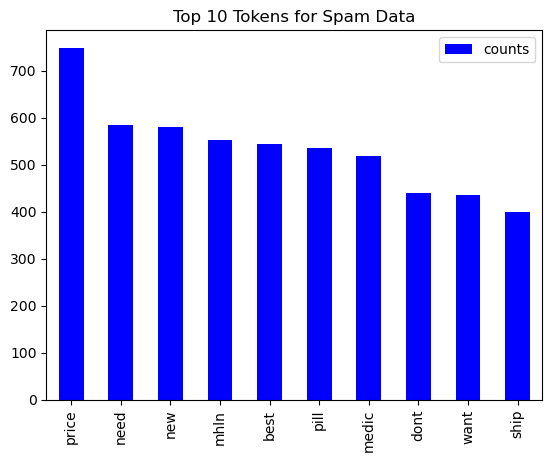

In [273]:
# Create CountVectorizer
vectorizer1 = CountVectorizer(min_df = 10,  
                             tokenizer=my_tokenizer,
                             ngram_range=(1, 1))

spam_data = sampled_data[sampled_data['label'] == 1]

# Fit and transform the "subject" column for spam and not spam separately
spam_subject_transformed = vectorizer1.fit_transform(spam_data['subject'])

word_counts_spam = pd.DataFrame(
    {"counts": spam_subject_transformed.toarray().sum(axis=0)},
    index=vectorizer1.get_feature_names_out()
).sort_values("counts", ascending=False)

# Create a figure and define the subplot grid
word_counts_spam.head(10).plot(kind='bar', color='b')
# plt.xlabel('Token')
# plt.ylabel("Frequency")
plt.title('Top 10 Tokens for Spam Data')
plt.show()

<Axes: >

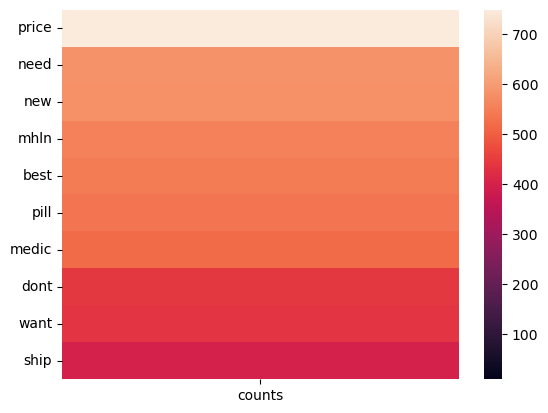

In [274]:
sns.heatmap(word_counts_spam.head(10),vmin=10,vmax=None)

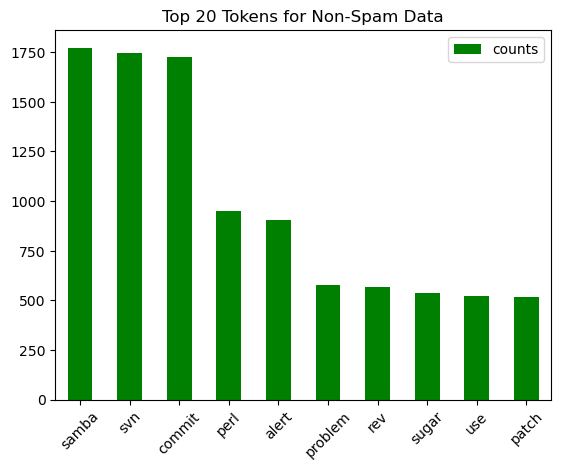

In [278]:
# Create CountVectorizer
vectorizer2 = CountVectorizer(min_df = 10,  
                             tokenizer=my_tokenizer,
                             ngram_range=(1, 1))

not_spam_data = sampled_data[sampled_data['label'] == 0]

# Fit and transform the "subject" column for spam and not spam separately
nonspam_subject_transformed = vectorizer2.fit_transform(not_spam_data['subject'])

word_counts_nonspam = pd.DataFrame(
    {"counts": nonspam_subject_transformed.toarray().sum(axis=0)},
    index=vectorizer2.get_feature_names_out()
).sort_values("counts", ascending=False)
              
# Plot the top 20 tokens for spam and not spam data
word_counts_nonspam.head(10).plot(kind='bar', color='g')
# plt.xlabel('Frequency')
# plt.ylabel("Token Count")
plt.title('Top 20 Tokens for Non-Spam Data')

plt.xticks(rotation=45)
plt.show()

<Axes: >

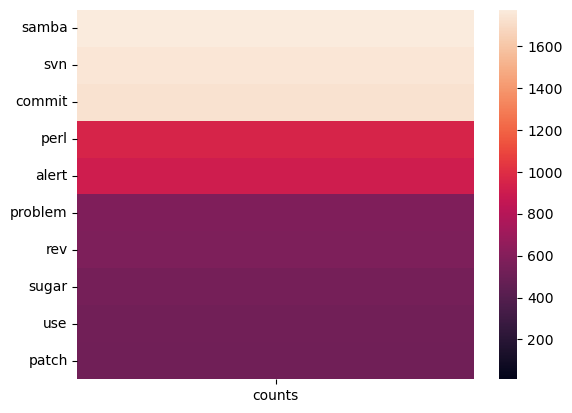

In [276]:
sns.heatmap(word_counts_nonspam.head(10),vmin=10,vmax=None)

**Optimizing min_df for 'subject'**

We are going to use TFid vectorizer for extracting features from email subject

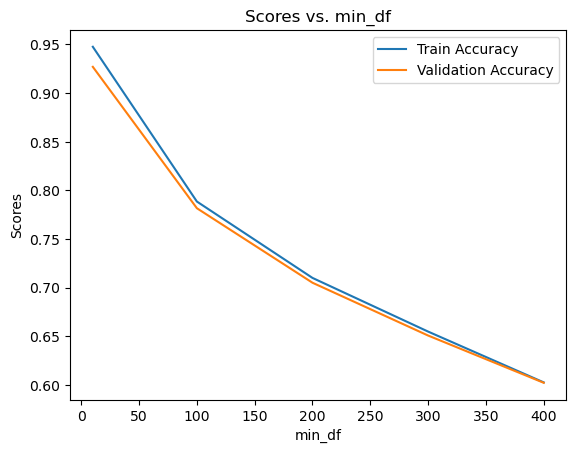

In [282]:
min_df_values = [10,100,200,300,400]
train_scores = []
val_scores = []

for min_df in min_df_values:
    # Instantiate tfid vectorizer
    vectorizer_subject = TfidfVectorizer(min_df = min_df,  
                             tokenizer=my_tokenizer,
                             ngram_range=(1, 1))

    # Fit and transform train set
    vectorized_subject_train = vectorizer_subject.fit_transform(X_train['subject'])
    # Get vectorized subject dataframe
    vectorized_subject_train_df = pd.DataFrame(vectorized_subject_train.todense(),
                                               columns=vectorizer_subject.get_feature_names_out())
    vectorized_subject_train_df = vectorized_subject_train_df.add_prefix('subject_')
    vectorized_subject_train_df.reset_index(drop=True, inplace=True)
    
    # Transform validation set
    vectorized_subject_val = vectorizer_subject.transform(X_validation['subject'])
    vectorized_subject_val_df = pd.DataFrame(vectorized_subject_val.todense(), 
                                             columns=vectorizer_subject.get_feature_names_out())
    vectorized_subject_val_df = vectorized_subject_val_df.add_prefix('subject_')
    vectorized_subject_val_df.reset_index(drop=True, inplace=True)
    
    # Define the steps for the Logistic Regression pipeline
    my_pipeline = [('scaler', StandardScaler()), 
                   ('model', LogisticRegression())
            ]
    pipeline = Pipeline(my_pipeline)
    pipeline.fit(vectorized_subject_train_df, y_train)
    
    # Calculate train accuracy
    train_accuracy = pipeline.score(vectorized_subject_train_df, y_train)
    train_scores.append(train_accuracy)
    
    # Calculate test accuracy
    val_accuracy = pipeline.score(vectorized_subject_val_df, y_validation)
    val_scores.append(val_accuracy)

# Plot the graph
plt.plot(min_df_values, train_scores, label='Train Accuracy')
plt.plot(min_df_values, val_scores, label='Validation Accuracy')
plt.xlabel('min_df')
plt.ylabel('Scores')
plt.title('Scores vs. min_df')
plt.legend()
plt.show()

We are going to choose the best min_df as the highest value when the validation accuracy above 70% and the absolute difference between validation and test accuracies are minimum.

In [283]:
# Find the indices where val_scores > 0.70
val_indices = np.where(np.array(val_scores) > 0.70)[0]

# Calculate the absolute difference between train_scores and val_scores
abs_diff = np.abs(np.array(train_scores) - np.array(val_scores))

# Find the index with the minimum absolute difference among the selected indices
valid_indices = val_indices[abs_diff[val_indices].argmin()]

# Get the corresponding best_n_features value
best_min_df = min_df_values[valid_indices]

best_min_df

200

Vectorize subject in the X_train. The result is converted to data frame and added a prefix for identification.

In [284]:
# Instantiate tfid vectorizer
vectorizer_subject = TfidfVectorizer(min_df = best_min_df,  
                             tokenizer=my_tokenizer,
                             ngram_range=(1, 1))

# Fit and transform train set
vectorized_subject_train = vectorizer_subject.fit_transform(X_train['subject'])

# View result
vectorized_subject_train_df = pd.DataFrame(vectorized_subject_train.todense(), 
                                           columns=vectorizer_subject.get_feature_names_out())
vectorized_subject_train_df = vectorized_subject_train_df.add_prefix('subject_')
vectorized_subject_train_df.reset_index(drop=True, inplace=True)
vectorized_subject_train_df

,subject_alert,subject_best,subject_branch,subject_bush,subject_cnn,subject_commit,subject_data,subject_discount,subject_dont,subject_file,subject_function,subject_help,subject_iphealth,subject_make,subject_medic,subject_mhln,subject_need,subject_new,subject_news,subject_notif,subject_patch,subject_perl,subject_pill,subject_price,subject_problem,subject_question,subject_rev,subject_samba,subject_ship,subject_softwar,subject_stock,subject_sugar,subject_svn,subject_test,subject_time,subject_use,subject_viagra,subject_want
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22395,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
22396,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0
22397,0.0,0.0,0.0,0.0,0.0,0.579246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.575553,0.0,0.0,0.0,0.0,0.577246,0.0,0.0,0.0,0.0,0.0
22398,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


Visualize the top words from the vectorised data.

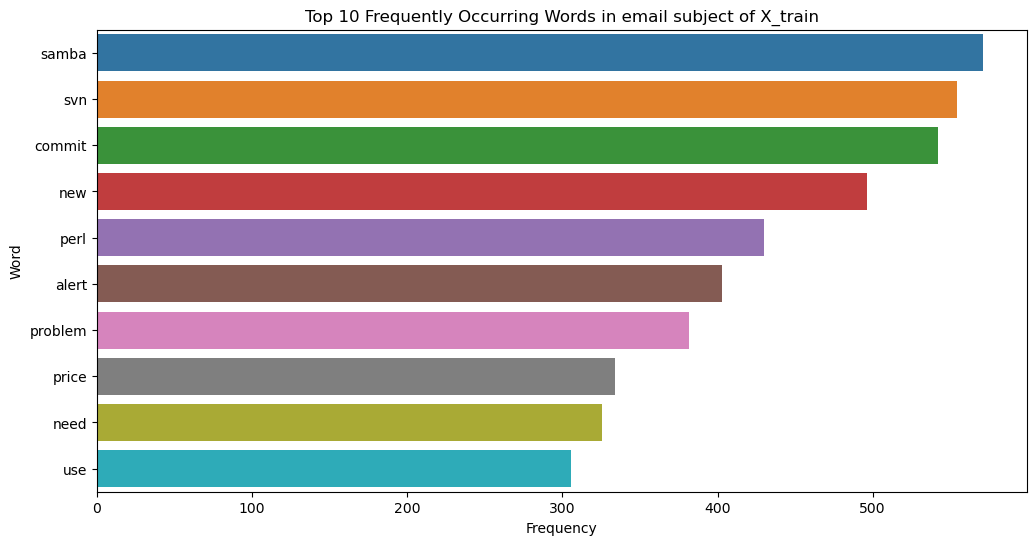

In [285]:
word_freq = vectorized_subject_train_df.sum().sort_values(ascending=False)
top_10_words = word_freq.head(10)

# Remove prefixes from column names
top_10_words.index = top_10_words.index.str.replace('subject_', '')

plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_words.values, y=top_10_words.index,errorbar=None)
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Top 10 Frequently Occurring Words in email subject of X_train')
plt.show()

Now, transform test and validation sets.

In [300]:
# Transform test set using the trained vectorizers
vectorized_subject_test = vectorizer_subject.transform(X_test['subject'])
vectorized_subject_test_df = pd.DataFrame(vectorized_subject_test.todense(), columns=vectorizer_subject.get_feature_names_out())
vectorized_subject_test_df = vectorized_subject_test_df.add_prefix('subject_')
vectorized_subject_test_df.reset_index(drop=True, inplace=True)

# Transform validation set using the trained vectorizers
vectorized_subject_val = vectorizer_subject.transform(X_validation['subject'])
vectorized_subject_val_df = pd.DataFrame(vectorized_subject_val.todense(), columns=vectorizer_subject.get_feature_names_out())
vectorized_subject_val_df = vectorized_subject_val_df.add_prefix('subject_')
vectorized_subject_val_df.reset_index(drop=True, inplace=True)

**Topic Modeling**

We are performing LDA on the text data from the 'subject' column, extracts five topics, and visualizes the results using pyLDAvis. The visualization will show the distribution of topics, the most relevant words for each topic, and their inter-topic distance.
 
The gensim.utils.simple_preprocess() function is used to preprocess the text data in the 'subject' column. It tokenizes the text (splits it into individual words), removes punctuation, converts the text to lowercase, and discards any words with a length less than or equal to 2 characters. The preprocessed text is stored in the processed_data list.

Gensim's Dictionary class is used to create a mapping between words and their unique integer ids. It takes the processed_data list as input and creates a dictionary of unique words present in the corpus.

The Bag of Words representation is a way to represent the text data in a format that is suitable for various topic modeling algorithms, including LDA. In this step, the corpus variable is created, which contains the Bag of Words representation of the text data. Each document in the corpus is represented as a list of tuples, where each tuple contains the word id and its frequency in the document.

The LDA model is created using the LdaModel class from Gensim. The corpus and dictionary are passed as inputs to the model. num_topics specifies the number of topics you want the model to discover. LDA will assign each document a probability distribution over the topics and each topic a probability distribution over the words.

The pyLDAvis library is used for visualizing the LDA results interactively. pyLDAvis.enable_notebook() enables the display of the visualization in Jupyter Notebook or Jupyter Lab. The gensimvis.prepare() function is called to prepare the LDA model, corpus, and dictionary for visualization. The resulting vis_data contains the data needed for the visualization. Finally, pyLDAvis.display(vis_data) displays the interactive pyLDAvis visualization in the notebook.
Source: <br>
https://medium.com/analytics-vidhya/topic-modeling-using-gensim-lda-in-python-48eaa2344920

In [292]:
# Preprocess text data
processed_data = [gensim.utils.simple_preprocess(doc) for doc in X_train['subject']]

# Create a dictionary from the processed data
dictionary = corpora.Dictionary(processed_data)

# Create a corpus (a bag of words representation) from the dictionary
corpus = [dictionary.doc2bow(doc) for doc in processed_data]

# Perform LDA
num_topics = 5  
lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)

# Visualize the LDA results using pyLDAvis
# This will display the visualization in Jupyter Notebook
pyLDAvis.enable_notebook()  
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

Now we get 5 topic clusters from the subject feature. These topics can be added as feature by determining which is the prominent topic in each subject value. This is done next and added to X_train.

In [293]:
# Get the dominant topic for each data point and add it as a new column in the DataFrame
def get_dominant_topic(lda_model, corpus):
    dominant_topic = []
    for doc in corpus:
        topic_distribution = lda_model[doc]
        dominant_topic.append(max(topic_distribution, key=lambda x: x[1])[0])
    return dominant_topic

X_train['prominent_topic'] = get_dominant_topic(lda_model, corpus)

# Display the DataFrame with the prominent topic column
X_train.head()

,subject,message,subject_Word_Count_clipped,message_Word_Count_clipped,email_from_hash_0,email_from_hash_1,email_from_hash_2,email_from_hash_3,email_from_hash_4,email_from_hash_5,email_from_hash_6,email_from_hash_7,email_from_hash_8,email_from_hash_9,email_from_hash_10,email_from_hash_11,email_from_hash_12,email_from_hash_13,email_from_hash_14,email_from_hash_15,email_from_hash_16,email_from_hash_17,email_from_hash_18,email_from_hash_19,email_from_hash_20,email_from_hash_21,email_from_hash_22,email_from_hash_23,email_from_hash_24,email_from_hash_25,email_from_hash_26,email_from_hash_27,email_from_hash_28,email_from_hash_29,email_from_hash_30,email_from_hash_31,email_from_hash_32,email_from_hash_33,email_from_hash_34,email_from_hash_35,email_from_hash_36,email_from_hash_37,email_from_hash_38,email_from_hash_39,email_from_hash_40,email_from_hash_41,email_from_hash_42,email_from_hash_43,email_from_hash_44,email_from_hash_45,email_from_hash_46,email_from_hash_47,email_from_hash_48,email_from_hash_49,email_from_hash_50,email_from_hash_51,email_from_hash_52,email_from_hash_53,email_from_hash_54,email_from_hash_55,email_from_hash_56,email_from_hash_57,email_from_hash_58,email_from_hash_59,email_from_hash_60,email_from_hash_61,email_from_hash_62,email_from_hash_63,email_from_hash_64,email_from_hash_65,email_from_hash_66,email_from_hash_67,email_from_hash_68,email_from_hash_69,host_transform__from_host_Others,host_transform__from_host_gmail,host_transform__from_host_gmx,host_transform__from_host_hotmail,host_transform__from_host_mail,host_transform__from_host_yahoo,domain_transform__from_domain_Others,domain_transform__from_domain_ca,domain_transform__from_domain_com,domain_transform__from_domain_edu,domain_transform__from_domain_net,domain_transform__from_domain_org,domain_transform__from_domain_uk,prominent_topic
0,Re: Proposal for SAMBA_3_0/README.Coding,-----BEGIN PGP SIGNED MESSAGE-----\nHash: SHA1...,4,93,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,In he ballantine,Does Size Matter?'\n____\n\n60% of WOMEN said ...,3,129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4
2,Why seek? Choose any love pi11 you want!,Content-Type: multipart/alternative;\n\tbounda...,8,338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,invitation to fill in the vacant position of a...,Content-Type: text/html;\nContent-Transfer-Enc...,11,568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2
4,"Windows server returning ""non specific error c...","Windows CIFS server (2003) is returning a ""Non...",7,175,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0

In [294]:
X_train['prominent_topic'].value_counts()

prominent_topic
0    5522
2    4920
1    4426
3    3985
4    3547
Name: count, dtype: int64

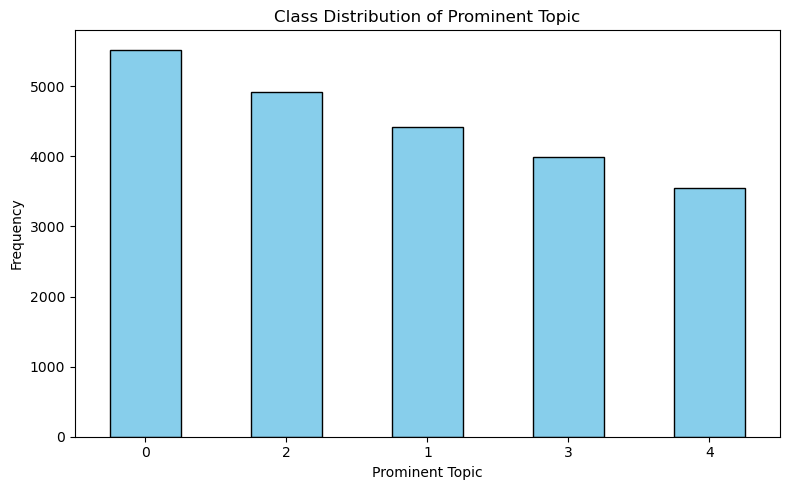

In [295]:
# Calculate the class distribution using value_counts()
class_distribution = X_train['prominent_topic'].value_counts()

# Create the class distribution plot
plt.figure(figsize=(8, 5))
class_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Prominent Topic')
plt.ylabel('Frequency')
plt.title('Class Distribution of Prominent Topic')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

The new feature has 5 values, each showing which topic is prominent for that particular subject. The class distribution is also not bad. We can one hot encode these values to preserve its information.

In [296]:
# Convert 'prominent_topic' column to string
X_train['prominent_topic'] = X_train['prominent_topic'].astype(str)

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the 'prominent_topic' column to obtain the one-hot encoded result
one_hot_encoded = encoder.fit_transform(X_train[['prominent_topic']])

# Convert the sparse matrix to a DataFrame
one_hot_encoded_df = pd.DataFrame(one_hot_encoded.toarray(), columns=encoder.get_feature_names_out(['prominent_topic']))

# Concatenate the one-hot encoded DataFrame with the original X_train DataFrame
X_train = pd.concat([X_train, one_hot_encoded_df], axis=1)

# Drop the original 'prominent_topic' column (since it is now one-hot encoded)
X_train.drop(columns=['prominent_topic'], inplace=True)
X_train.head()

,subject,message,subject_Word_Count_clipped,message_Word_Count_clipped,email_from_hash_0,email_from_hash_1,email_from_hash_2,email_from_hash_3,email_from_hash_4,email_from_hash_5,email_from_hash_6,email_from_hash_7,email_from_hash_8,email_from_hash_9,email_from_hash_10,email_from_hash_11,email_from_hash_12,email_from_hash_13,email_from_hash_14,email_from_hash_15,email_from_hash_16,email_from_hash_17,email_from_hash_18,email_from_hash_19,email_from_hash_20,email_from_hash_21,email_from_hash_22,email_from_hash_23,email_from_hash_24,email_from_hash_25,email_from_hash_26,email_from_hash_27,email_from_hash_28,email_from_hash_29,email_from_hash_30,email_from_hash_31,email_from_hash_32,email_from_hash_33,email_from_hash_34,email_from_hash_35,email_from_hash_36,email_from_hash_37,email_from_hash_38,email_from_hash_39,email_from_hash_40,email_from_hash_41,email_from_hash_42,email_from_hash_43,email_from_hash_44,email_from_hash_45,email_from_hash_46,email_from_hash_47,email_from_hash_48,email_from_hash_49,email_from_hash_50,email_from_hash_51,email_from_hash_52,email_from_hash_53,email_from_hash_54,email_from_hash_55,email_from_hash_56,email_from_hash_57,email_from_hash_58,email_from_hash_59,email_from_hash_60,email_from_hash_61,email_from_hash_62,email_from_hash_63,email_from_hash_64,email_from_hash_65,email_from_hash_66,email_from_hash_67,email_from_hash_68,email_from_hash_69,host_transform__from_host_Others,host_transform__from_host_gmail,host_transform__from_host_gmx,host_transform__from_host_hotmail,host_transform__from_host_mail,host_transform__from_host_yahoo,domain_transform__from_domain_Others,domain_transform__from_domain_ca,domain_transform__from_domain_com,domain_transform__from_domain_edu,domain_transform__from_domain_net,domain_transform__from_domain_org,domain_transform__from_domain_uk,prominent_topic_0,prominent_topic_1,prominent_topic_2,prominent_topic_3,prominent_topic_4
0,Re: Proposal for SAMBA_3_0/README.Coding,-----BEGIN PGP SIGNED MESSAGE-----\nHash: SHA1...,4,93,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,In he ballantine,Does Size Matter?'\n____\n\n60% of WOMEN said ...,3,129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Why seek? Choose any love pi11 you want!,Content-Type: multipart/alternative;\n\tbounda...,8,338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,invitation to fill in the vacant position of a...,Content-Type: text/html;\nContent-Transfer-Enc...,11,568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,"Windows server returning ""non specific error c...","Windows CIFS server (2003) is returning a ""Non...",7,175,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

Now we apply the same transformaton for test and validation sets.

In [297]:
# Preprocess text data
processed_data = [gensim.utils.simple_preprocess(doc) for doc in X_test['subject']]

# Create a dictionary from the processed data
dictionary = corpora.Dictionary(processed_data)

# Create a corpus (a bag of words representation) from the dictionary
corpus = [dictionary.doc2bow(doc) for doc in processed_data]

# Perform LDA
num_topics = 5  
lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)

# Get the dominant topic for each data point and add it as a new column in the DataFrame
def get_dominant_topic(lda_model, corpus):
    dominant_topic = []
    for doc in corpus:
        topic_distribution = lda_model[doc]
        dominant_topic.append(max(topic_distribution, key=lambda x: x[1])[0])
    return dominant_topic

X_test['prominent_topic'] = get_dominant_topic(lda_model, corpus)

# Convert 'prominent_topic' column to string
X_test['prominent_topic'] = X_test['prominent_topic'].astype(str)

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the 'prominent_topic' column to obtain the one-hot encoded result
one_hot_encoded = encoder.fit_transform(X_test[['prominent_topic']])

# Convert the sparse matrix to a DataFrame
one_hot_encoded_df = pd.DataFrame(one_hot_encoded.toarray(), columns=encoder.get_feature_names_out(['prominent_topic']))

# Concatenate the one-hot encoded DataFrame with the original X_train DataFrame
X_test = pd.concat([X_test, one_hot_encoded_df], axis=1)

# Drop the original 'prominent_topic' column (since it is now one-hot encoded)
X_test.drop(columns=['prominent_topic'], inplace=True)
X_test.head()

,subject,message,subject_Word_Count_clipped,message_Word_Count_clipped,email_from_hash_0,email_from_hash_1,email_from_hash_2,email_from_hash_3,email_from_hash_4,email_from_hash_5,email_from_hash_6,email_from_hash_7,email_from_hash_8,email_from_hash_9,email_from_hash_10,email_from_hash_11,email_from_hash_12,email_from_hash_13,email_from_hash_14,email_from_hash_15,email_from_hash_16,email_from_hash_17,email_from_hash_18,email_from_hash_19,email_from_hash_20,email_from_hash_21,email_from_hash_22,email_from_hash_23,email_from_hash_24,email_from_hash_25,email_from_hash_26,email_from_hash_27,email_from_hash_28,email_from_hash_29,email_from_hash_30,email_from_hash_31,email_from_hash_32,email_from_hash_33,email_from_hash_34,email_from_hash_35,email_from_hash_36,email_from_hash_37,email_from_hash_38,email_from_hash_39,email_from_hash_40,email_from_hash_41,email_from_hash_42,email_from_hash_43,email_from_hash_44,email_from_hash_45,email_from_hash_46,email_from_hash_47,email_from_hash_48,email_from_hash_49,email_from_hash_50,email_from_hash_51,email_from_hash_52,email_from_hash_53,email_from_hash_54,email_from_hash_55,email_from_hash_56,email_from_hash_57,email_from_hash_58,email_from_hash_59,email_from_hash_60,email_from_hash_61,email_from_hash_62,email_from_hash_63,email_from_hash_64,email_from_hash_65,email_from_hash_66,email_from_hash_67,email_from_hash_68,email_from_hash_69,host_transform__from_host_Others,host_transform__from_host_gmail,host_transform__from_host_gmx,host_transform__from_host_hotmail,host_transform__from_host_mail,host_transform__from_host_yahoo,domain_transform__from_domain_Others,domain_transform__from_domain_ca,domain_transform__from_domain_com,domain_transform__from_domain_edu,domain_transform__from_domain_net,domain_transform__from_domain_org,domain_transform__from_domain_uk,prominent_topic_0,prominent_topic_1,prominent_topic_2,prominent_topic_3,prominent_topic_4
0,Increase Your Odds of Getting a Grant,You registered to receive this and similar off...,7,208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,due to expansion of activities our company is ...,Content-Type: text/html;\nContent-Transfer-Enc...,20,574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,Re: gentoo dropping speakup support,-----BEGIN PGP SIGNED MESSAGE-----\nHash: SHA1...,5,124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,Dude check out this sweet site,Content-Type: text/plain; charset=Windows-1252...,6,313,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,svn commit: samba r22383 - in\n\tbranches/SAMB...,Author: metze\nDate: 2007-04-19 17:29:57 +0000...,8,65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [298]:
# Preprocess text data
processed_data = [gensim.utils.simple_preprocess(doc) for doc in X_validation['subject']]

# Create a dictionary from the processed data
dictionary = corpora.Dictionary(processed_data)

# Create a corpus (a bag of words representation) from the dictionary
corpus = [dictionary.doc2bow(doc) for doc in processed_data]

# Perform LDA
num_topics = 5  
lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)

# Get the dominant topic for each data point and add it as a new column in the DataFrame
def get_dominant_topic(lda_model, corpus):
    dominant_topic = []
    for doc in corpus:
        topic_distribution = lda_model[doc]
        dominant_topic.append(max(topic_distribution, key=lambda x: x[1])[0])
    return dominant_topic

X_validation['prominent_topic'] = get_dominant_topic(lda_model, corpus)

# Convert 'prominent_topic' column to string
X_validation['prominent_topic'] = X_validation['prominent_topic'].astype(str)

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the 'prominent_topic' column to obtain the one-hot encoded result
one_hot_encoded = encoder.fit_transform(X_validation[['prominent_topic']])

# Convert the sparse matrix to a DataFrame
one_hot_encoded_df = pd.DataFrame(one_hot_encoded.toarray(), columns=encoder.get_feature_names_out(['prominent_topic']))

# Concatenate the one-hot encoded DataFrame with the original X_train DataFrame
X_validation = pd.concat([X_validation, one_hot_encoded_df], axis=1)

# Drop the original 'prominent_topic' column (since it is now one-hot encoded)
X_validation.drop(columns=['prominent_topic'], inplace=True)
X_validation.head()

,subject,message,subject_Word_Count_clipped,message_Word_Count_clipped,email_from_hash_0,email_from_hash_1,email_from_hash_2,email_from_hash_3,email_from_hash_4,email_from_hash_5,email_from_hash_6,email_from_hash_7,email_from_hash_8,email_from_hash_9,email_from_hash_10,email_from_hash_11,email_from_hash_12,email_from_hash_13,email_from_hash_14,email_from_hash_15,email_from_hash_16,email_from_hash_17,email_from_hash_18,email_from_hash_19,email_from_hash_20,email_from_hash_21,email_from_hash_22,email_from_hash_23,email_from_hash_24,email_from_hash_25,email_from_hash_26,email_from_hash_27,email_from_hash_28,email_from_hash_29,email_from_hash_30,email_from_hash_31,email_from_hash_32,email_from_hash_33,email_from_hash_34,email_from_hash_35,email_from_hash_36,email_from_hash_37,email_from_hash_38,email_from_hash_39,email_from_hash_40,email_from_hash_41,email_from_hash_42,email_from_hash_43,email_from_hash_44,email_from_hash_45,email_from_hash_46,email_from_hash_47,email_from_hash_48,email_from_hash_49,email_from_hash_50,email_from_hash_51,email_from_hash_52,email_from_hash_53,email_from_hash_54,email_from_hash_55,email_from_hash_56,email_from_hash_57,email_from_hash_58,email_from_hash_59,email_from_hash_60,email_from_hash_61,email_from_hash_62,email_from_hash_63,email_from_hash_64,email_from_hash_65,email_from_hash_66,email_from_hash_67,email_from_hash_68,email_from_hash_69,host_transform__from_host_Others,host_transform__from_host_gmail,host_transform__from_host_gmx,host_transform__from_host_hotmail,host_transform__from_host_mail,host_transform__from_host_yahoo,domain_transform__from_domain_Others,domain_transform__from_domain_ca,domain_transform__from_domain_com,domain_transform__from_domain_edu,domain_transform__from_domain_net,domain_transform__from_domain_org,domain_transform__from_domain_uk,prominent_topic_0,prominent_topic_1,prominent_topic_2,prominent_topic_3,prominent_topic_4
0,[Ip-health] Venezuela: Antitrust Authorities S...,Estudio Antequera Parilli & Rodriguez\nVenezue...,11,765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Your removal from the MORNINGGRIND list,"Sun, 24 Jun 2007 00:01:15\n\nYou have been au...",6,262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,Job just for you. [letter id: 5525411527],Content-Type: text/html;\nContent-Transfer-Enc...,7,588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,"Re: Thank you for your recent application, we ...","Content-Type: text/html;\n\tcharset=""us-ascii""...",19,98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,Immense gains in germany.,PCWindows,4,1,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

Now we are going to drop the original subject column and also join the tfid vectorized dataframe to the original sets.

In [302]:
# Use concat_and_drop function to recreate X_train, X_test, X_validation and X_remainder
X_train = concat_and_drop(X_train, vectorized_subject_train_df, 'subject')
X_test = concat_and_drop(X_test, vectorized_subject_test_df, 'subject')
X_validation = concat_and_drop(X_validation, vectorized_subject_val_df, 'subject')

In [303]:
# Check the shape
print(f'The shape of X_train is {X_train.shape}')
print(f'The shape of X_test is {X_test.shape}')
print(f'The shape of X_validation is {X_validation.shape}')

The shape of X_train is (22400, 129)
The shape of X_test is (12000, 129)
The shape of X_validation is (5600, 129)


In [304]:
# View the head of X_train
X_train.head()

,message,subject_Word_Count_clipped,message_Word_Count_clipped,email_from_hash_0,email_from_hash_1,email_from_hash_2,email_from_hash_3,email_from_hash_4,email_from_hash_5,email_from_hash_6,email_from_hash_7,email_from_hash_8,email_from_hash_9,email_from_hash_10,email_from_hash_11,email_from_hash_12,email_from_hash_13,email_from_hash_14,email_from_hash_15,email_from_hash_16,email_from_hash_17,email_from_hash_18,email_from_hash_19,email_from_hash_20,email_from_hash_21,email_from_hash_22,email_from_hash_23,email_from_hash_24,email_from_hash_25,email_from_hash_26,email_from_hash_27,email_from_hash_28,email_from_hash_29,email_from_hash_30,email_from_hash_31,email_from_hash_32,email_from_hash_33,email_from_hash_34,email_from_hash_35,email_from_hash_36,email_from_hash_37,email_from_hash_38,email_from_hash_39,email_from_hash_40,email_from_hash_41,email_from_hash_42,email_from_hash_43,email_from_hash_44,email_from_hash_45,email_from_hash_46,email_from_hash_47,email_from_hash_48,email_from_hash_49,email_from_hash_50,email_from_hash_51,email_from_hash_52,email_from_hash_53,email_from_hash_54,email_from_hash_55,email_from_hash_56,email_from_hash_57,email_from_hash_58,email_from_hash_59,email_from_hash_60,email_from_hash_61,email_from_hash_62,email_from_hash_63,email_from_hash_64,email_from_hash_65,email_from_hash_66,email_from_hash_67,email_from_hash_68,email_from_hash_69,host_transform__from_host_Others,host_transform__from_host_gmail,host_transform__from_host_gmx,host_transform__from_host_hotmail,host_transform__from_host_mail,host_transform__from_host_yahoo,domain_transform__from_domain_Others,domain_transform__from_domain_ca,domain_transform__from_domain_com,domain_transform__from_domain_edu,domain_transform__from_domain_net,domain_transform__from_domain_org,domain_transform__from_domain_uk,prominent_topic_0,prominent_topic_1,prominent_topic_2,prominent_topic_3,prominent_topic_4,subject_alert,subject_best,subject_branch,subject_bush,subject_cnn,subject_commit,subject_data,subject_discount,subject_dont,subject_file,subject_function,subject_help,subject_iphealth,subject_make,subject_medic,subject_mhln,subject_need,subject_new,subject_news,subject_notif,subject_patch,subject_perl,subject_pill,subject_price,subject_problem,subject_question,subject_rev,subject_samba,subject_ship,subject_softwar,subject_stock,subject_sugar,subject_svn,subject_test,subject_time,subject_use,subject_viagra,subject_want
0,-----BEGIN PGP SIGNED MESSAGE-----\nHash: SHA1...,4,93,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Does Size Matter?'\n____\n\n60% of WOMEN said ...,3,129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Content-Type: multipart/alternative;\n\tbounda...,8,338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

<a id = "msg"></a>
## 7. Feature 4: message

Check a random message value.

In [308]:
X_train['message'][18]

'Content-Type: text/plain;\n  charset="iso-8859-1"\nContent-Transfer-Encoding: quoted-printable\nContent-Disposition: inline\n\nAm Mittwoch, 4. Juli 2007 schrieb Joe Smith:\n> "Ben Finney" wrote in message\n> news:876451ox1v.fsf@benfinney.id.au...\n>\n> > Dennis Schridde writes:\n> >> This is not Debian related, but I think you are the ones who know\n> >> best about licensing issues.\n> >\n> > This list, debian-legal, is a resource for Debian developers to\n> > determine whether a work is free software compliant with the DFSG. Its\n> > regular members contribute largely on the understanding that they\'re\n> > helping the Debian project.\nIf you can\'t help, I guess there is no one else who can?\n(Implicit question: Whom else could I ask?)\n\n> Yes.\n>\n> For what its worth, The code looks non-free (by DFSG and FSF standards). =\nIt\n> is definately not GPL compatible.\n> The code does look distributable, but only in non-free, and I\'m not certa=\nin\n> of that either (did not look clos

We need to clean and extract the text from the message value. First we are extracting the text using BeautifulSoup. Then another helper function is used to get the words from the result.

In [311]:
# Clean the 'message' column using the extract_HTML_text function
X_train['message'] = X_train['message'].apply(extract_HTML_text)
X_train.head()

,message,subject_Word_Count_clipped,message_Word_Count_clipped,email_from_hash_0,email_from_hash_1,email_from_hash_2,email_from_hash_3,email_from_hash_4,email_from_hash_5,email_from_hash_6,email_from_hash_7,email_from_hash_8,email_from_hash_9,email_from_hash_10,email_from_hash_11,email_from_hash_12,email_from_hash_13,email_from_hash_14,email_from_hash_15,email_from_hash_16,email_from_hash_17,email_from_hash_18,email_from_hash_19,email_from_hash_20,email_from_hash_21,email_from_hash_22,email_from_hash_23,email_from_hash_24,email_from_hash_25,email_from_hash_26,email_from_hash_27,email_from_hash_28,email_from_hash_29,email_from_hash_30,email_from_hash_31,email_from_hash_32,email_from_hash_33,email_from_hash_34,email_from_hash_35,email_from_hash_36,email_from_hash_37,email_from_hash_38,email_from_hash_39,email_from_hash_40,email_from_hash_41,email_from_hash_42,email_from_hash_43,email_from_hash_44,email_from_hash_45,email_from_hash_46,email_from_hash_47,email_from_hash_48,email_from_hash_49,email_from_hash_50,email_from_hash_51,email_from_hash_52,email_from_hash_53,email_from_hash_54,email_from_hash_55,email_from_hash_56,email_from_hash_57,email_from_hash_58,email_from_hash_59,email_from_hash_60,email_from_hash_61,email_from_hash_62,email_from_hash_63,email_from_hash_64,email_from_hash_65,email_from_hash_66,email_from_hash_67,email_from_hash_68,email_from_hash_69,host_transform__from_host_Others,host_transform__from_host_gmail,host_transform__from_host_gmx,host_transform__from_host_hotmail,host_transform__from_host_mail,host_transform__from_host_yahoo,domain_transform__from_domain_Others,domain_transform__from_domain_ca,domain_transform__from_domain_com,domain_transform__from_domain_edu,domain_transform__from_domain_net,domain_transform__from_domain_org,domain_transform__from_domain_uk,prominent_topic_0,prominent_topic_1,prominent_topic_2,prominent_topic_3,prominent_topic_4,subject_alert,subject_best,subject_branch,subject_bush,subject_cnn,subject_commit,subject_data,subject_discount,subject_dont,subject_file,subject_function,subject_help,subject_iphealth,subject_make,subject_medic,subject_mhln,subject_need,subject_new,subject_news,subject_notif,subject_patch,subject_perl,subject_pill,subject_price,subject_problem,subject_question,subject_rev,subject_samba,subject_ship,subject_softwar,subject_stock,subject_sugar,subject_svn,subject_test,subject_time,subject_use,subject_viagra,subject_want
0,-----BEGIN PGP SIGNED MESSAGE-----\nHash: SHA1...,4,93,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Does Size Matter?'\n____\n\n60% of WOMEN said ...,3,129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Content-Type: multipart/alternative;\n\tbounda...,8,338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [312]:
# Clean the 'message' column using the extract_text_content function
X_train['message'] = X_train['message'].apply(extract_text_content, english_words=nltk_eng_words)
X_train.head()

,message,subject_Word_Count_clipped,message_Word_Count_clipped,email_from_hash_0,email_from_hash_1,email_from_hash_2,email_from_hash_3,email_from_hash_4,email_from_hash_5,email_from_hash_6,email_from_hash_7,email_from_hash_8,email_from_hash_9,email_from_hash_10,email_from_hash_11,email_from_hash_12,email_from_hash_13,email_from_hash_14,email_from_hash_15,email_from_hash_16,email_from_hash_17,email_from_hash_18,email_from_hash_19,email_from_hash_20,email_from_hash_21,email_from_hash_22,email_from_hash_23,email_from_hash_24,email_from_hash_25,email_from_hash_26,email_from_hash_27,email_from_hash_28,email_from_hash_29,email_from_hash_30,email_from_hash_31,email_from_hash_32,email_from_hash_33,email_from_hash_34,email_from_hash_35,email_from_hash_36,email_from_hash_37,email_from_hash_38,email_from_hash_39,email_from_hash_40,email_from_hash_41,email_from_hash_42,email_from_hash_43,email_from_hash_44,email_from_hash_45,email_from_hash_46,email_from_hash_47,email_from_hash_48,email_from_hash_49,email_from_hash_50,email_from_hash_51,email_from_hash_52,email_from_hash_53,email_from_hash_54,email_from_hash_55,email_from_hash_56,email_from_hash_57,email_from_hash_58,email_from_hash_59,email_from_hash_60,email_from_hash_61,email_from_hash_62,email_from_hash_63,email_from_hash_64,email_from_hash_65,email_from_hash_66,email_from_hash_67,email_from_hash_68,email_from_hash_69,host_transform__from_host_Others,host_transform__from_host_gmail,host_transform__from_host_gmx,host_transform__from_host_hotmail,host_transform__from_host_mail,host_transform__from_host_yahoo,domain_transform__from_domain_Others,domain_transform__from_domain_ca,domain_transform__from_domain_com,domain_transform__from_domain_edu,domain_transform__from_domain_net,domain_transform__from_domain_org,domain_transform__from_domain_uk,prominent_topic_0,prominent_topic_1,prominent_topic_2,prominent_topic_3,prominent_topic_4,subject_alert,subject_best,subject_branch,subject_bush,subject_cnn,subject_commit,subject_data,subject_discount,subject_dont,subject_file,subject_function,subject_help,subject_iphealth,subject_make,subject_medic,subject_mhln,subject_need,subject_new,subject_news,subject_notif,subject_patch,subject_perl,subject_pill,subject_price,subject_problem,subject_question,subject_rev,subject_samba,subject_ship,subject_softwar,subject_stock,subject_sugar,subject_svn,subject_test,subject_time,subject_use,subject_viagra,subject_want
0,BEGIN MESSAGE Hash SHA Jerry Carter wrote wrot...,4,93,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Does Size Matter of said were UNHAPPY with the...,3,129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Content Type alternative boundary koi Content ...,8,338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [313]:
# Checking the same message again to verify the cleaned message
X_train['message'][18]

'iso Content Transfer printable Content Disposition Am Joe Smith Ben wrote in message news ox id This is not related but I think you are the who know best about This list legal is a resource for to determine whether a work is free compliant with the Its regular contribute largely on the understanding that they re helping the project If you can help I guess there is no one else who can Implicit question Whom else could I ask Yes For what its worth The code non free by and It is not compatible The code does look distributable but only in non free and I not in of that either did not look closely enough That is about all the he will be likely to get from this list unless and until the program is for and or a legal Trying again anyway since when I don get from anywhere I can work on it freely so I won work on it at all and it perhaps won ever for Vicious circle Is this thing or any license in general if that could be more easily somehow mixable with the that I publish my derived work under 

Now we have successfully cleaned the messages, we can proceed to do feature extraction process.

**Sentence Embeddings**

Sentence embeddings are numeric representations of words and text, much like bag-of-words (BoW) or TF-IDF, most commonly produced by neural networks. One crucial difference is that the embeddings produced by neural networks are relatively low dimensional and dense vectors, 100 to 600 dimensions with most values non-zero, compared to a typical bag-of-words representation that could run to the thousands but most values are zero. This makes word embeddings more computationally tractable.

In [315]:
# We can then load up a gensim model with these Wikipedia word vectors (this will take a few minutes):
model = gensim.models.KeyedVectors.load_word2vec_format(
    'lexvec-wikipedia-word-vectors', binary=False #trained on a dataset scarped form wikipedia
)

Now, we are going to visually represent the embeddings of two spam email subjects (sentences) using a pre-trained word embedding model. The aggregation of word embeddings to form sentence embeddings allows us to capture the overall semantic representation of the sentences in a lower-dimensional space for visualization. This process enables us to understand how the model interprets the context and content of the spam email subjects based on the word embeddings learned during its training.

Filtering Data: We start by filtering a DataFrame called sampled_data to obtain rows corresponding to the "spam" class. The label column is assumed to contain binary labels, where 1 represents spam emails.

Preparing Sample Sentences: From the filtered data, we extract the 'message' column and convert it to a list called message_list. We then randomly sample two sentences (emails) from message_list to visualize their embeddings.

Cleaning Sentences: Each selected sentence is cleaned using the extract_HTML_text and extract_text_content functions. These functions might remove any HTML tags or other unwanted content from the sentences, leaving only the text content.

In [321]:
# Filter the DataFrame to get subjects of spam class
filtered_data = sampled_data[sampled_data['label'] == 1]
message_list = filtered_data['message'].tolist()

# Take any two random values from the message_list for plotting
num_samples = 2
sentence_list = random.sample(message_list, num_samples)

# Clean the 'message' using the extract_text_content function
sentence_list = [extract_HTML_text(sentence) for sentence in sentence_list]
sentence_list = [extract_text_content(sentence, nltk_eng_words) for sentence in sentence_list]
sentence_list

['The cream of the crop for GET IN EARLY IS SET TO ROCK YOUR PORTFOLIO Direct Symbol Price There is a MASSIVE PROMOTION underway this weekend This is hot read the news and get on first thing Excellent are In your past define your percentage of time spent in the home office and in the field record preferred Also perform for hot rolled and built up steel in cold formed specialty A large firm is seeking a very senior Instrumentation and Engineer to lead its staff in Why would you consider this area Experience in or power industry is a must working in field construction or maintenance office environment The ability to lead and train is a must Candidate will direct the condition based maintenance program to optimize the utilization of maintenance appropriate to assess equipment i',
 'iso Content Transfer bit Nice to meet you Visit our new pharmacy store and save We have special for you FOR AS LOW AS PER DOSE super FOR AS LOW AS PER DOSE FOR AS LOW AS PER DOSE and much much more for you toda

Word Embedding Visualization: For each cleaned sentence, we perform the following steps:

- Split the sentence into individual words.
- Get the word embeddings for each word using the model. If a word is not present in the model's vocabulary (i.e., an out-of-vocabulary word), we handle it gracefully by using a default embedding (a zero vector).
- Aggregate the word embeddings (using the mean in this example) to obtain the sentence embedding, representing the overall content of the sentence.
- Plot the sentence embeddings as images to visualize the embeddings' representations. The embedding vector for each sentence is repeated vertically ten times to create a visual representation.

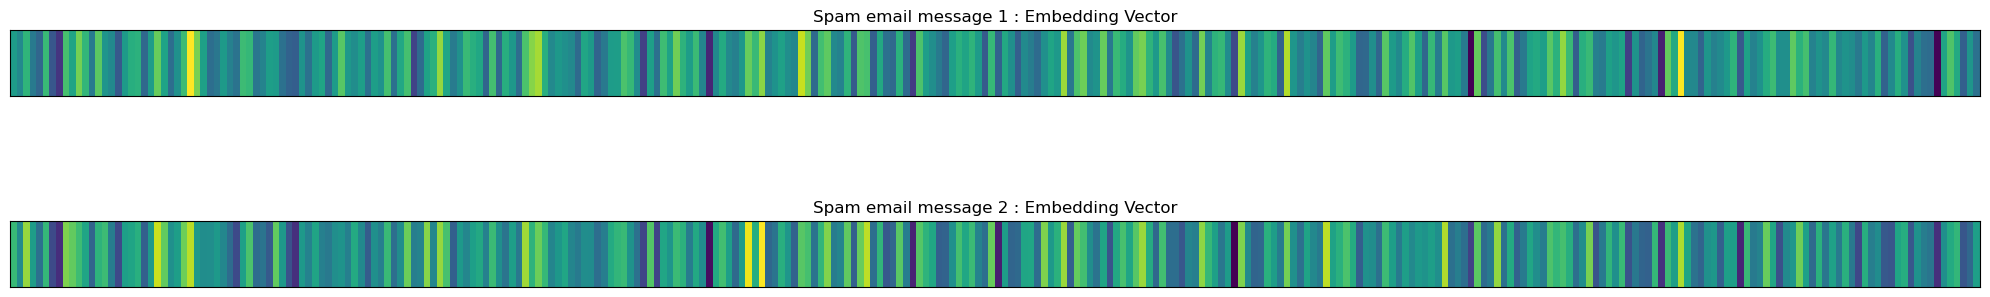

In [322]:
plt.subplots(len(sentence_list), 1, figsize=(20, 5))

for i, sentence in enumerate(sentence_list):
    # Split the sentence into words
    words = sentence.split()
    
    # Get the embeddings for each word or use a default embedding for out-of-vocabulary (OOV) words
    embeddings = [get_embedding(word, model) for word in words]
    
    # Concatenate the embeddings to get the sentence embedding
    sentence_embedding = np.mean(embeddings, axis=0)  # You can use other aggregation functions as well
    
    plt.subplot(len(sentence_list), 1, i + 1)
    plt.imshow(np.tile(sentence_embedding, (10, 1)))
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Spam email message {i+1} : Embedding Vector")

plt.tight_layout()
plt.show()

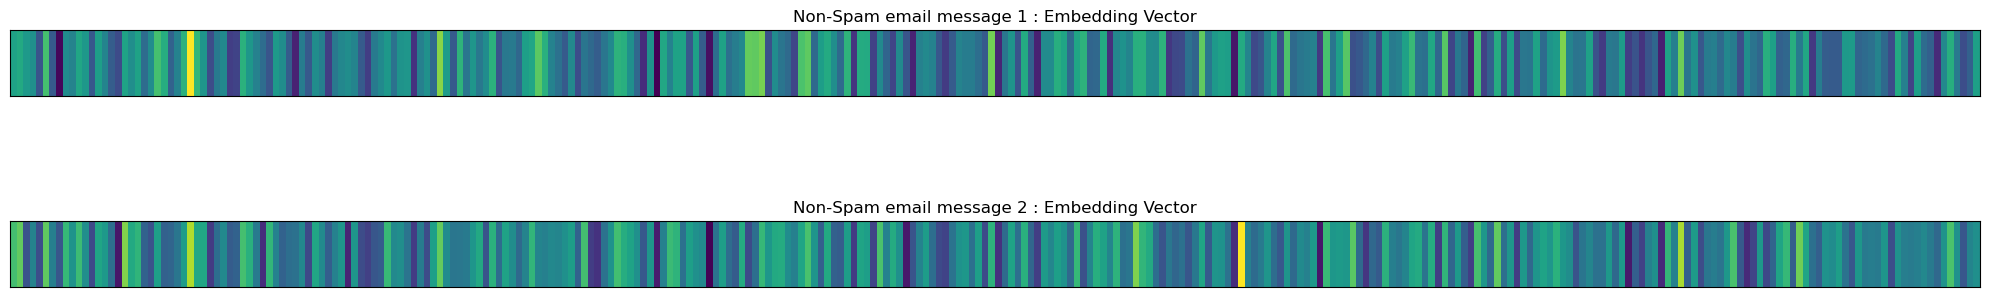

In [323]:
# Filter the DataFrame to get subjects of non spam class
filtered_data = sampled_data[sampled_data['label'] == 0]
message_list = filtered_data['message'].tolist()

# Take any two random values from the message_list for plotting
num_samples = 2
sentence_list = random.sample(message_list, num_samples)

# Clean the 'message' using the extract_text_content function
sentence_list = [extract_HTML_text(sentence) for sentence in sentence_list]
sentence_list = [extract_text_content(sentence, nltk_eng_words) for sentence in sentence_list]

plt.subplots(len(sentence_list), 1, figsize=(20, 5))

for i, sentence in enumerate(sentence_list):
    # Split the sentence into words
    words = sentence.split()
    
    # Get the embeddings for each word or use a default embedding for out-of-vocabulary (OOV) words
    embeddings = [get_embedding(word, model) for word in words]
    
    # Concatenate the embeddings to get the sentence embedding
    sentence_embedding = np.mean(embeddings, axis=0)  # You can use other aggregation functions as well
    
    plt.subplot(len(sentence_list), 1, i + 1)
    plt.imshow(np.tile(sentence_embedding, (10, 1)))
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Non-Spam email message {i+1} : Embedding Vector")

plt.tight_layout()
plt.show()

These visuals help to percieve the similarity of two messages of spam and non spam classes.